In [ ]:
########################################################################################################################
####-------| NOTE 1.A. IMPORTS LIBRARIES | XXX -----------------------------------------------------####################
########################################################################################################################


"""Train CIFAR100 with PyTorch."""

# Python 2/3 compatibility
# from __future__ import print_function


# Standard libraries
import sys
import os
import argparse
from tqdm import tqdm
import math
import random
import numpy as np


# PyTorch and related modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# torchvision for datasets and transforms
import torchvision
import torchvision.transforms as transforms
import torch_optimizer as torch_opt  # Use 'torch_opt' for torch_optimizer
from timm.scheduler import CosineLRScheduler 
from torch.optim.lr_scheduler import OneCycleLR





# ✅ Define currect working directory to ensure on right directory
VGG16_PATH = r"C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget"
if os.getcwd() != VGG16_PATH:
    os.chdir(VGG16_PATH)
print(f"✅ Current working directory: {os.getcwd()}")

# ✅ Define absolute paths
PROJECT_PATH = VGG16_PATH
MODELS_PATH = os.path.join(VGG16_PATH, "models")
ACTIVATION_PATH = os.path.join(VGG16_PATH, "activation")
# PAU_PATH = os.path.join(VGG16_PATH, "pau")

# ✅ Ensure necessary paths are in sys.path
for path in [PROJECT_PATH, MODELS_PATH, ACTIVATION_PATH]:
    if path not in sys.path:
        sys.path.append(path)

# ✅ Print updated sys.path for debugging
print("✅ sys.path updated:")
for path in sys.path:
    print("   📂", path)

# ✅ Import FFTGate (Check if the module exists)
try:
    from activation.FFTGate import FFTGate  # type: ignore
    print("✅ FFTGate imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ Import failed: {e}")
    print(f"🔍 Check that 'Activation4.py' exists inside: {ACTIVATION_PATH}")

# ✅ Test if FFTGate is callable
try:
    activation_test = FFTGate()
    print("✅ FFTGate instance created successfully!")
except Exception as e:
    print(f"❌ Error while initializing FFTGate: {e}")

# ✅ Now import FFTGate_VGG (Ensure module exists inside models/)
try:
    from models.FFTGate_VGG import FFTGate_VGG  # type: ignore
    print("✅ FFTGate_VGG imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ FFTGate_VGG import failed: {e}")
    print(f"🔍 Check that 'FFTGate_VGG.py' exists inside: {MODELS_PATH}")






########################################################################################################################
####-------| NOTE 1.B. SEEDING FOR REPRODUCIBILITY | XXX -------------------------------------------####################
########################################################################################################################

def set_seed_torch(seed):
    torch.manual_seed(seed)                          



def set_seed_main(seed):
    random.seed(seed)                                ## Python's random module
    np.random.seed(seed)                             ## NumPy's random module
    torch.cuda.manual_seed(seed)                     ## PyTorch's random module for CUDA
    torch.cuda.manual_seed_all(seed)                 ## Seed for all CUDA devices
    torch.backends.cudnn.deterministic = True        ## Ensure deterministic behavior for CuDNN
    torch.backends.cudnn.benchmark = False           ## Disable CuDNN's autotuning for reproducibility



# Variable seed for DataLoader shuffling
set_seed_torch(1)   

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  







# (Optional) Import Optimizers - Uncomment as needed
# from Opt import opt
# from diffGrad import diffGrad
# from diffRGrad import diffRGrad, SdiffRGrad, BetaDiffRGrad, Beta12DiffRGrad, BetaDFCDiffRGrad
# from RADAM import Radam, BetaRadam
# from BetaAdam import BetaAdam, BetaAdam1, BetaAdam2, BetaAdam3, BetaAdam4, BetaAdam5, BetaAdam6, BetaAdam7, BetaAdam4A
# from AdamRM import AdamRM, AdamRM1, AdamRM2, AdamRM3, AdamRM4, AdamRM5
# from sadam import sadam
# from SdiffGrad import SdiffGrad
# from SRADAM import SRADAM






########################################################################################################################
####-------| NOTE 2. DEFINE MODEL Lr | XXX ---------------------------------------------------------####################
########################################################################################################################

# Main Execution (Placeholder)
if __name__ == "__main__":
    print("CIFAR100 Training Script Initialized...")
    # Add your training pipeline here


import argparse
import os

# Argument parser to get user inputs
parser = argparse.ArgumentParser(description='PyTorch CIFAR100 Training')
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')

args, unknown = parser.parse_known_args()  # Avoids Jupyter argument issues
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure lr is correctly parsed
lr = args.lr  # Get learning rate from argparse
lr_str = str(lr).replace('.', '_')  # Convert to string and replace '.' for filenames

# Debugging prints
print(f"Using device: {device}")
print(f"Parsed learning rate: {lr} (type: {type(lr)})")
print(f"Formatted learning rate for filenames: {lr_str}")

# Initialize training variables
best_acc = 0  # Best test accuracy
start_epoch = 0  # Start from epoch 0 or last checkpoint epoch







########################################################################################################################
####-------| NOTE 3. LOAD DATASET | XXX ------------------------------------------------------------####################
########################################################################################################################

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

bs = 64 #set batch size
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=0)
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')





# ✅ Length of train and test datasets
len_train = len(trainset)
len_test = len(testset)
print(f"Length of training dataset: {len_train}")
print(f"Length of testing dataset: {len_test}")

# ✅ Print number of classes
num_classes_Print = len(trainset.classes)
print(f"Number of classes in CIFAR-100: {num_classes_Print}")





########################################################################################################################
####-------| NOTE 4. DYNAMIC REGULARIZATION| XXX ---------------------------------------------------####################
########################################################################################################################

def apply_dynamic_regularization(inputs, feature_activations, epoch,
                                  prev_params, layer_index_map, batch_idx):


    global activation_layers  # ✅ Reference already-collected layers

    # ✅ Print gamma1 stats early in training for monitoring
    if batch_idx == 0 and epoch <= 4:
        print(f"\n🚨 ENTERED apply_dynamic_regularization | Epoch={epoch} | Batch={batch_idx}", flush=True)

        # 🧠 Print gamma1 details
        all_layer_info = []
        for idx, layer in enumerate(activation_layers):
            param = getattr(layer, "gamma1")
            all_layer_info.append(f"Layer {idx}: ID={id(param)} | Mean={param.mean().item():.5f}")
        print("🧠 GAMMA1 INFO:", " | ".join(all_layer_info), flush=True)

    # ✅ Initialize gamma1 regularization accumulator
    gamma1_reg = 0.0

    # ✅ Compute batch std and define regularization strength
    batch_std = torch.std(inputs) + 1e-6
    regularization_strength = 0.05 if epoch < 40 else (0.01 if epoch < 60 else 0.005)

    # ✅ Track layers where noise is injected (informative)
    noisy_layers = []
    for idx, layer in enumerate(activation_layers):
        if idx not in layer_index_map:
            continue

        prev_layer_params = prev_params[layer_index_map[idx]]
        param_name = "gamma1"
        param = getattr(layer, param_name)
        prev_param = prev_layer_params[param_name]

        # # ✅ Target based on input stats
        # target = compute_target(param_name, batch_std)

        # # ✅ Adaptive Target Regularization
        # gamma1_reg += regularization_strength * (param - target).pow(2).mean() * 1.2

        # ✅ Adaptive Cohesion Regularization
        cohesion = (param - prev_param).pow(2)
        gamma1_reg += 0.005 * cohesion.mean()

        # ✅ Adaptive Noise Regularization
        epoch_AddNoise = 50
        if epoch > epoch_AddNoise:
            param_variation = torch.abs(param - prev_param).mean()
            if param_variation < 0.015:
                noise = (0.001 + 0.0004 * batch_std.item()) * torch.randn_like(param)
                penalty = (param - (prev_param + noise)).pow(2).sum()
                gamma1_reg += 0.00015 * penalty
                noisy_layers.append(f"{idx} (Δ={param_variation.item():.5f})") # Collect index and variation

    # ✅ Print noise injection summary
    if batch_idx == 0 and epoch <= (epoch_AddNoise + 4) and noisy_layers:
        print(f"🔥 Stable Noise Injected | Epoch {epoch} | Batch {batch_idx} | Layers: " + ", ".join(noisy_layers), flush=True)
    mags = feature_activations.abs().mean(dim=(0, 2, 3))
    m = mags / mags.sum()
    gamma1_reg += 0.005 * (-(m * torch.log(m + 1e-6)).sum())

    return gamma1_reg


def compute_target(param_name, batch_std):
    if param_name == "gamma1":
        return 2.0 + 0.2 * batch_std.item()  

    raise ValueError(f"Unknown param {param_name}")






########################################################################################################################
####-------| NOTE 5. INITIALIZE MODEL | XXX --------------------------------------------------------####################
########################################################################################################################

# Model
print('==> Building model..')
#net = Elliott_VGG('VGG16'); net1 = 'Elliott_VGG16'
#net = GELU_MobileNet(); net1 = 'GELU_MobileNet'
#net = GELU_SENet18(); net1 = 'GELU_SENet18'
#net = PDELU_ResNet50(); net1 = 'PDELU_ResNet50'
# net = Sigmoid_GoogLeNet(); net1 = 'Sigmoid_GoogLeNet'
#net = GELU_DenseNet121(); net1 = 'GELU_DenseNet121'
# net = ReLU_VGG('VGG16'); net1 = 'ReLU_VGG16'
net = FFTGate_VGG('VGG16'); net1 = 'FFTGate_VGG16'


net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9); optimizer1 = 'SGDM5'
#optimizer = optim.Adagrad(net.parameters()); optimizer1 = 'AdaGrad'
#optimizer = optim.Adadelta(net.parameters()); optimizer1 = 'AdaDelta'
#optimizer = optim.RMSprop(net.parameters()); optimizer1 = 'RMSprop'
optimizer = optim.Adam(net.parameters(), lr=args.lr); optimizer1 = 'Adam'
#optimizer = optim.Adam(net.parameters(), lr=args.lr, amsgrad=True); optimizer1 = 'amsgrad'
#optimizer = diffGrad(net.parameters(), lr=args.lr); optimizer1 = 'diffGrad'
#optimizer = Radam(net.parameters(), lr=args.lr); optimizer1 = 'Radam'







########################################################################################################################
####-------| NOTE 6. INITIALIZE ACTIVATION PARAMETERS, OPTIMIZERS & SCHEDULERS | XXX ---------------####################
########################################################################################################################

import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# ✅ Step 1: Collect Activation Parameters from ALL Layers (Ensure Compatibility with DataParallel)
if isinstance(net, torch.nn.DataParallel):
    features = net.module.features
else:
    features = net.features





# ✅ Step 2: Recursively search for FFTGate layers
activation_params = []
activation_layers = []

for layer in features:
    if isinstance(layer, FFTGate):  
        activation_layers.append(layer)
        activation_params.append(layer.gamma1)  # ✅ Only gamma1 is trainable





# ✅ Step 3: Define Unfreeze Epoch
unfreeze_activation_epoch = 1  # ✅ Change this value if needed
# unfreeze_activation_epoch = 10  # ✅ Delay unfreezing until epoch 10


# ✅ Define the warm-up epoch value
# WARMUP_ACTIVATION_EPOCHS = 5  # The number of epochs for warm-up
WARMUP_ACTIVATION_EPOCHS = 0  # The number of epochs for warm-up


# ✅ Step 4: Initially Freeze Activation Parameters
for param in activation_params:
    param.requires_grad = False  # 🚫 Keep frozen before the unfreeze epoch




# ✅ Step 4: Initialize Activation Optimizers (Using AdamW for Better Weight Decay)
activation_optimizers = {
    "gamma1": torch.optim.AdamW(activation_params, lr=0.0015, weight_decay=1e-6)  # 🔺 Reduce LR from 0.005 → 0.0025
}




# ✅ Step 5: Initialize Activation Schedulers with Warm Restarts (Per Parameter Type)
activation_schedulers = {
    "gamma1": CosineAnnealingWarmRestarts(
        activation_optimizers["gamma1"],
        T_0=10,      # Shorter cycle to explore aggressively
        T_mult=2,    # Increase cycle length gradually
        eta_min=5e-5  # ✅ recommended safer modification
    )
}





# ✅ Step 6: Print collected activation layers and parameters
if activation_layers and activation_params:
    print(f"✅ Found {len(activation_layers)} FFTGate layers.")
    print(f"✅ Collected {len(activation_params)} trainable activation parameters.")
    
    for idx, layer in enumerate(activation_layers):
        print(f"   🔹 Layer {idx}: {layer}")

elif activation_layers and not activation_params:
    print(f"⚠ Warning: Found {len(activation_layers)} FFTGate layers, but no trainable parameters were collected.")

elif activation_params and not activation_layers:
    print(f"⚠ Warning: Collected {len(activation_params)} activation parameters, but no FFTGate layers were recorded.")

else:
    print("⚠ Warning: No FFTGate layers or activation parameters found! Skipping activation optimizer.")
    activation_optimizers = None


########################################################################################################################
####-------| NOTE 7. INITIALIZE MAIN OPTIMIZER SCHEDULER | XXX -------------------------------------####################
########################################################################################################################

# ✅ Step 6: Define MultiStepLR for Main Optimizer
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)

main_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)






########################################################################################################################
####-------| NOTE 8. MODEL CHECK POINT | XXX -------------------------------------------------------####################
########################################################################################################################

import os
import torch

# Ensure directories exist
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')

if not os.path.exists('Results'):
    os.makedirs('Results')

# Construct checkpoint path
checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr}_{net1}_{optimizer1}.t7'

# Resume checkpoint only if file exists
if args.resume:
    print('==> Resuming from checkpoint..')
    
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded: {checkpoint_path}")
    else:
        print(f"Error: Checkpoint file not found: {checkpoint_path}")





########################################################################################################################
####-------| NOTE 9. DEFINE TRAIN LOOP | XXX -------------------------------------------------------####################
########################################################################################################################

# ✅ Used for naming files 
target_mode = "no_target"  # Options: "no_target", "target"

# Training

def train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler , WARMUP_ACTIVATION_EPOCHS):
    global train_loss_history, best_train_acc, prev_params, recent_test_acc, gamma1_history, activation_layers, test_acc_history, train_acc_history, target_mode  # 🟢🟢🟢

    if epoch == 0:
        train_loss_history = []
        train_acc_history = []
        best_train_acc = 0.0
        recent_test_acc = 0.0
        gamma1_history = {}         # ✅ Initialize history
        test_acc_history = []       # ✅ test accuracy history



    prev_params = {}
    layer_index_map = {idx: idx for idx in range(len(activation_layers))}  

    # ✅ Cache previous gamma1 values from activation layers
    for idx, layer in enumerate(activation_layers):
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }



    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_accuracy = 0.0

    # ✅ Initialize log history
    log_history = []



    # ✅ Define path to store Training log
    save_paths = {
       
        "log_history": f"C:\\Users\\emeka\\Research\\ModelCUDA\\Big_Data_Journal\\Comparison\\Code\\Paper\\github2\\AblationExperiments\\AdaptiveTarget-No_AdaptiveTarget\\Results\\FFTGate\\FFTGate_training_logs.txt"  # ✅ Training log_history 
    }




    # ✅ Step 1: Unfreeze Activation Parameters (Only Once Per Epoch)
    if epoch == unfreeze_activation_epoch:
        print("\n🔓 Unfreezing Activation Function Parameters 🔓")
        for layer in net.module.features if isinstance(net, torch.nn.DataParallel) else net.features:
            if isinstance(layer, FFTGate):   
                layer.gamma1.requires_grad = True  # ✅ Only gamma1 is trainable
        print("✅ Activation Parameters Unfrozen! 🚀")





    # ✅ Step 2: Gradual Warm-up for Activation Learning Rates (AFTER Unfreezing)
    warmup_start = unfreeze_activation_epoch  # 🔹 Start warm-up when unfreezing happens
    warmup_end = unfreeze_activation_epoch + WARMUP_ACTIVATION_EPOCHS  # 🔹 End warm-up period

    # ✅ Adjust learning rates **only** during the warm-up phase
    if warmup_start <= epoch < warmup_end:
        warmup_factor = (epoch - warmup_start + 1) / WARMUP_ACTIVATION_EPOCHS  

        for name, act_scheduler in activation_schedulers.items():
            for param_group in act_scheduler.optimizer.param_groups:
                if "initial_lr" not in param_group:
                    param_group["initial_lr"] = param_group["lr"]  # 🔹 Store initial LR
                param_group["lr"] = param_group["initial_lr"] * warmup_factor  # 🔹 Scale LR

        # ✅ Debugging output to track warm-up process
        print(f"🔥 Warm-up Epoch {epoch}: Scaling LR by {warmup_factor:.3f}")
        for name, act_scheduler in activation_schedulers.items():
            print(f"  🔹 {name} LR: {act_scheduler.optimizer.param_groups[0]['lr']:.6f}")






    activation_history = []  # 🔴 Initialize empty history at start of epoch (outside batch loop)



    # ✅ Training Loop
    with tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch}") as progress:
        for batch_idx, (inputs, targets) in progress:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()


            # zero_grad activation parameter
            for opt in activation_optimizers.values():
                opt.zero_grad()


            # ✅ Forward Pass
            outputs = net(inputs, epoch=epoch, train_accuracy=train_accuracy, targets=targets)
            loss = criterion(outputs, targets)

            
            feature_activations = features(inputs)  # Feature activations


            # ✅ Collect Activation History | ✅ Per-layer mean activations
            batch_means = [layer.saved_output.mean().item() for layer in activation_layers]
            activation_history.extend(batch_means)

            # ✅ Apply Decay strategy to history for each activation layer
            with torch.no_grad():
                for layer in activation_layers:
                    if isinstance(layer, FFTGate):
                        layer.decay_spectral_history(epoch, num_epochs)




            # ✅ Compute Training Accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            train_accuracy = 100. * correct / total if total > 0 else 0.0  # Compute training accuracy






            # ✅ Call Regularization Function for the Activation Parameter
            if epoch > 0:
                gamma1_reg = apply_dynamic_regularization(
                    inputs, feature_activations, epoch,
                    prev_params, layer_index_map, batch_idx
                )
                loss += gamma1_reg






            # ✅ Backward pass
            loss.backward()



            # ✅ 🎯 Adaptive Gradient Clipping of gamma1  
            for layer in features:
                if isinstance(layer, FFTGate):  # ✅ Ensure layer has gamma1 before clipping
                    torch.nn.utils.clip_grad_norm_([layer.gamma1], max_norm=0.7)
                        



            # ✅ Apply Optimizer Step for Model Parameters
            optimizer.step()

            # ✅ Apply Optimizer Steps for Activation Parameters (Only if Unfrozen)
            if epoch >= unfreeze_activation_epoch:
                for opt in activation_optimizers.values():
                    opt.step()


            # ✅ Accumulate loss
            train_loss += loss.item()



            # ✅ Clamping of gamma1 (Applied AFTER Optimizer Step)
            with torch.no_grad():
                for layer in activation_layers:
                    layer.gamma1.clamp_(0.1, 6.0)  




            # ✅ Update progress bar
            progress.set_postfix(Train_loss=round(train_loss / (batch_idx + 1), 3),
                                 Train_acc=train_accuracy)  



    # ✅ Step the main optimizer scheduler (ONLY for model parameters)
    main_scheduler.step()

    # ✅ Step the activation parameter schedulers (ONLY for activation parameters) | Epoch-wise stepping
    if epoch >= unfreeze_activation_epoch:
        for name, act_scheduler in activation_schedulers.items():  
            act_scheduler.step()  




    # ✅ ONLY update prev_params here AFTER all updates | ✅ Update prev_params AFTER training epoch
    for idx, layer in enumerate(activation_layers):      
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }




    # ✅ Logging Activation Parameters & Gradients
    last_batch_grads = {"Gamma1 Grad": []}
    current_params = {"Gamma1": []}

    for layer in features:
        if isinstance(layer, FFTGate):  
            # ✅ Convert gradients to scalar floats and format to 5 decimal places (removes device='cuda:0' and tensor(...))
            last_batch_grads["Gamma1 Grad"].append(f"{layer.gamma1.grad.item():.5f}" if layer.gamma1.grad is not None else "None")

            # ✅ Collect current parameter values (already scalar), formatted to 5 decimal places
            current_params["Gamma1"].append(f"{layer.gamma1.item():.5f}")

    # ✅ Build log message (showing params and gradients for ALL layers)
    log_msg = (
        f"Epoch {epoch}: M_Optimizer LR => {optimizer.param_groups[0]['lr']:.5f} | "
        f"Gamma1 LR => {activation_optimizers['gamma1'].param_groups[0]['lr']:.5f} | "
        f"Gamma1: {current_params['Gamma1']} | "
        f"Gamma1 Grad: {last_batch_grads['Gamma1 Grad']}"
    )

    log_history.append(log_msg)
    print(log_msg)  # ✅ Prints only once per epoch




    # ✅ Initialize log file at the beginning of training (Clear old logs)
    if epoch == 0:  # ✅ Only clear at the start of training
        with open(save_paths["log_history"], "w", encoding="utf-8") as log_file:
            log_file.write("")  # ✅ Clears previous logs

    # ✅ Save logs once per epoch (Append new logs)
    if log_history:
        with open(save_paths["log_history"], "a", encoding="utf-8") as log_file:
            log_file.write("\n".join(log_history) + "\n")         # ✅ Ensure each entry is on a new line
        print(f"📜 Logs saved to {save_paths['log_history']}!")  # ✅ Only prints once per epoch
    else:
        print("⚠ No logs to save!")




    # ✅ Compute final training accuracy for the epoch
    final_train_loss = train_loss / len(trainloader)
    final_train_acc = 100. * correct / total

    # ✅ Append to history
    train_loss_history.append(final_train_loss)

    # Append per-epoch training accuracy
    train_acc_history.append(final_train_acc)




    # ✅ Save training results (without affecting best accuracy tracking)
    train_results_path = f'./Results/CIFAR100_Train_{target_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'

    # ✅ Clear the log file at the start of training (Epoch 0)
    if epoch == 0 and os.path.exists(train_results_path):
        with open(train_results_path, 'w') as f:
            f.write("")  # ✅ Clears previous logs only once

    # ✅ Append new training results for each epoch
    with open(train_results_path, 'a') as f:
        f.write(f"Epoch {epoch} | Train Loss: {final_train_loss:.3f} | Train Acc: {final_train_acc:.3f}%\n")

    if final_train_acc > best_train_acc:
        best_train_acc = final_train_acc  # ✅ Update best training accuracy
        print(f"🏆 New Best Training Accuracy: {best_train_acc:.3f}% (Updated)")

    # ✅ Append the best training accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):  # Only log once at the final epoch
        with open(train_results_path, 'a') as f:
            f.write(f"\n🏆 Best Training Accuracy: {best_train_acc:.3f}%\n")  

    # ✅ Print both Final and Best Training Accuracy
    print(f"📊 Train Accuracy: {final_train_acc:.3f}% | 🏆 Best Train Accuracy: {best_train_acc:.3f}%")




    print(f"📜 Training logs saved to {train_results_path}!")
    print(f"🏆 Best Training Accuracy: {best_train_acc:.3f}% (Updated)")



    if epoch % 10 == 0:
        print(f"📏 Sizes → ActivationHist: {len(activation_history)} | TestAccHist: {len(test_acc_history)} | TrainLossHist: {len(train_loss_history)}")



    # return final_train_loss, final_train_acc, feature_activations













########################################################################################################################
####-------| NOTE 10. DEFINE TEST LOOP | XXX -------------------------------------------------------####################
########################################################################################################################


import os
import torch
from tqdm import tqdm

def test(epoch, save_results=True):
    """
    Evaluates the model on the test set and optionally saves the results.
    
    Args:
    - epoch (int): The current epoch number.
    - save_results (bool): Whether to save results to a file.

    Returns:
    - acc (float): Test accuracy percentage.
    """
    global best_acc, val_accuracy, target_mode  
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    # ✅ Ensure activation function parameters are clamped before evaluation
    with torch.no_grad():
        with tqdm(enumerate(testloader), total=len(testloader), desc=f"Testing Epoch {epoch}") as progress:
            for batch_idx, (inputs, targets) in progress:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # ✅ Pass validation accuracy to activation function
                val_accuracy = 100. * correct / total if total > 0 else 0


                # ✅ Update progress bar with loss & accuracy
                progress.set_postfix(Test_loss=round(test_loss / (batch_idx + 1), 3),
                                     Test_acc=round(val_accuracy, 3))



    # ✅ Compute final test accuracy
    final_test_loss = test_loss / len(testloader)
    final_test_acc = 100. * correct / total






    # ✅ Ensure "Results" folder exists (just like training logs)
    results_dir = os.path.join(PROJECT_PATH, "Results")
    os.makedirs(results_dir, exist_ok=True)

    # ✅ Define log file path for test results
    test_results_path = os.path.join(results_dir, f'CIFAR100_Test_{target_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt')

    # ✅ Initialize log file at the beginning of training (clear old logs)
    if epoch == 0:
        with open(test_results_path, 'w', encoding="utf-8") as f:
            f.write("")  # ✅ Clears previous logs

    # ✅ Append new test results for each epoch (same style as training)
    with open(test_results_path, 'a', encoding="utf-8") as f:
        f.write(f"Epoch {epoch} | Test Loss: {final_test_loss:.3f} | Test Acc: {final_test_acc:.3f}%\n")







    # ✅ Save checkpoint if accuracy improves (does NOT interfere with logging)
    if final_test_acc > best_acc:
        print('🏆 Saving best model...')
        state = {
            'net': net.state_dict(),
            'acc': final_test_acc,  # ✅ Ensures the best test accuracy is saved in checkpoint
            'epoch': epoch,
        }




        # Ensure checkpoint directory exists
        checkpoint_dir = "checkpoint"
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)


        # ✅ Format learning rate properly before saving filename
        lr_str = str(lr).replace('.', '_')
        checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr_str}_{net1}_{optimizer1}.t7'
        torch.save(state, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


        best_acc = final_test_acc  # ✅ Update best accuracy




    # ✅ Append the best test accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):
        with open(test_results_path, 'a', encoding="utf-8") as f:
            f.write(f"\n🏆 Best Test Accuracy: {best_acc:.3f}%\n")



    # ✅ Print both Final and Best Test Accuracy (always executed)
    print(f"📊 Test Accuracy: {final_test_acc:.3f}% | 🏆 Best Test Accuracy: {best_acc:.3f}%")
    print(f"📜 Test logs saved to {test_results_path}!")


    global recent_test_acc
    recent_test_acc = final_test_acc  # Capture latest test accuracy for next train() call | Store latest test accuracy

    test_acc_history.append(final_test_acc)

    return final_test_acc  # ✅ Return the test accuracy

✅ Current working directory: C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget
✅ sys.path updated:
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\python310.zip
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\DLLs
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env
   📂 
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\Pythonwin
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\models
   📂 C:\Users\emeka\Research\

In [ ]:
########################################################################################################################
####-------| NOTE 11. TRAIN MODEL WITH SHEDULAR | XXX ----------------------------------------------####################
########################################################################################################################



# ✅ Set Seed for Reproducibility BEFORE training starts

# Variable seed for DataLoader shuffling
set_seed_torch(1)  

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  

# ✅ Training Loop
num_epochs = 100 # Example: Set the total number of epochs
for epoch in range(start_epoch, num_epochs):   # Runs training for 100 epochs

    train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler, WARMUP_ACTIVATION_EPOCHS) # ✅ Pass required arguments

    test(epoch)  # ✅ Test the model
    tqdm.write("")  # ✅ Clear leftover progress bar from test()


print("Best Test Accuracy: ", best_acc)

Epoch 0: 100%|██████████| 782/782 [00:24<00:00, 31.99it/s, Train_acc=3.32, Train_loss=4.36]


Epoch 0: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000'] | Gamma1 Grad: ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 3.318% (Updated)
📊 Train Accuracy: 3.318% | 🏆 Best Train Accuracy: 3.318%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 3.318% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 0 | TrainLossHist: 1


Testing Epoch 0: 100%|██████████| 157/157 [00:01<00:00, 86.89it/s, Test_acc=5.57, Test_loss=4.03]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 5.570% | 🏆 Best Test Accuracy: 5.570%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!


🔓 Unfreezing Activation Function Parameters 🔓
✅ Activation Parameters Unfrozen! 🚀


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=1 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1740812433376 | Mean=1.50000 | Layer 1: ID=1740812434256 | Mean=1.50000 | Layer 2: ID=1740812435136 | Mean=1.50000 | Layer 3: ID=1740811565584 | Mean=1.50000 | Layer 4: ID=1740812228928 | Mean=1.50000 | Layer 5: ID=1740779637392 | Mean=1.50000 | Layer 6: ID=1740779637152 | Mean=1.50000 | Layer 7: ID=1740779636512 | Mean=1.50000 | Layer 8: ID=1740779635232 | Mean=1.50000 | Layer 9: ID=1741479133328 | Mean=1.50000 | Layer 10: ID=1741479134208 | Mean=1.50000 | Layer 11: ID=1741479135168 | Mean=1.50000 | Layer 12: ID=1741479136048 | Mean=1.50000


Epoch 1: 100%|██████████| 782/782 [00:32<00:00, 23.92it/s, Train_acc=6.89, Train_loss=3.97]


Epoch 1: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['1.62149', '1.70355', '1.57857', '1.52780', '1.48826', '1.44972', '1.41787', '1.43428', '1.42900', '1.45857', '1.36140', '1.38568', '1.34046'] | Gamma1 Grad: ['0.02444', '-0.00401', '0.02007', '-0.00367', '-0.01653', '-0.01799', '-0.02253', '0.00090', '-0.02339', '-0.01909', '-0.00756', '-0.04755', '0.00403']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 6.892% (Updated)
📊 Train Accuracy: 6.892% | 🏆 Best Train Accuracy: 6.892%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 6.892% (Updated)


Testing Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 80.02it/s, Test_acc=7.84, Test_loss=3.86]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 7.840% | 🏆 Best Test Accuracy: 7.840%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=2 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1740812433376 | Mean=1.62149 | Layer 1: ID=1740812434256 | Mean=1.70355 | Layer 2: ID=1740812435136 | Mean=1.57857 | Layer 3: ID=1740811565584 | Mean=1.52780 | Layer 4: ID=1740812228928 | Mean=1.48826 | Layer 5: ID=1740779637392 | Mean=1.44972 | Layer 6: ID=1740779637152 | Mean=1.41787 | Layer 7: ID=1740779636512 | Mean=1.43428 | Layer 8: ID=1740779635232 | Mean=1.42900 | Layer 9: ID=1741479133328 | Mean=1.45857 | Layer 10: ID=1741479134208 | Mean=1.36140 | Layer 11: ID=1741479135168 | Mean=1.38568 | Layer 12: ID=1741479136048 | Mean=1.34046


Epoch 2: 100%|██████████| 782/782 [00:33<00:00, 23.63it/s, Train_acc=10.6, Train_loss=3.67]


Epoch 2: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['1.79554', '1.95681', '1.77666', '1.58175', '1.52110', '1.38685', '1.33921', '1.41416', '1.38207', '1.41924', '1.23744', '1.42220', '1.16919'] | Gamma1 Grad: ['-0.02758', '-0.00124', '0.00605', '-0.01545', '-0.01844', '-0.01280', '-0.01697', '0.01768', '-0.02750', '-0.01356', '0.01835', '0.01467', '-0.05312']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 10.584% (Updated)
📊 Train Accuracy: 10.584% | 🏆 Best Train Accuracy: 10.584%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 10.584% (Updated)


Testing Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 79.10it/s, Test_acc=13.4, Test_loss=3.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 13.430% | 🏆 Best Test Accuracy: 13.430%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=3 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1740812433376 | Mean=1.79554 | Layer 1: ID=1740812434256 | Mean=1.95681 | Layer 2: ID=1740812435136 | Mean=1.77666 | Layer 3: ID=1740811565584 | Mean=1.58175 | Layer 4: ID=1740812228928 | Mean=1.52110 | Layer 5: ID=1740779637392 | Mean=1.38685 | Layer 6: ID=1740779637152 | Mean=1.33921 | Layer 7: ID=1740779636512 | Mean=1.41416 | Layer 8: ID=1740779635232 | Mean=1.38207 | Layer 9: ID=1741479133328 | Mean=1.41924 | Layer 10: ID=1741479134208 | Mean=1.23744 | Layer 11: ID=1741479135168 | Mean=1.42220 | Layer 12: ID=1741479136048 | Mean=1.16919


Epoch 3: 100%|██████████| 782/782 [00:32<00:00, 24.04it/s, Train_acc=15, Train_loss=3.38]  


Epoch 3: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['1.98998', '2.19797', '1.97166', '1.68982', '1.65595', '1.40768', '1.28233', '1.36814', '1.27393', '1.37339', '1.13249', '1.37989', '1.11099'] | Gamma1 Grad: ['0.01566', '0.01194', '-0.00829', '0.01546', '0.00996', '0.01476', '-0.01447', '0.00297', '-0.05540', '-0.04216', '-0.01724', '-0.17542', '-0.10998']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 15.020% (Updated)
📊 Train Accuracy: 15.020% | 🏆 Best Train Accuracy: 15.020%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 15.020% (Updated)


Testing Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 85.53it/s, Test_acc=18.7, Test_loss=3.15]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 18.740% | 🏆 Best Test Accuracy: 18.740%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=4 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1740812433376 | Mean=1.98998 | Layer 1: ID=1740812434256 | Mean=2.19797 | Layer 2: ID=1740812435136 | Mean=1.97166 | Layer 3: ID=1740811565584 | Mean=1.68982 | Layer 4: ID=1740812228928 | Mean=1.65595 | Layer 5: ID=1740779637392 | Mean=1.40768 | Layer 6: ID=1740779637152 | Mean=1.28233 | Layer 7: ID=1740779636512 | Mean=1.36814 | Layer 8: ID=1740779635232 | Mean=1.27393 | Layer 9: ID=1741479133328 | Mean=1.37339 | Layer 10: ID=1741479134208 | Mean=1.13249 | Layer 11: ID=1741479135168 | Mean=1.37989 | Layer 12: ID=1741479136048 | Mean=1.11099


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.67it/s, Train_acc=20.1, Train_loss=3.1] 


Epoch 4: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.17789', '2.40724', '2.14625', '1.80848', '1.80226', '1.53097', '1.26171', '1.39170', '1.19210', '1.34526', '1.02741', '1.33835', '1.14901'] | Gamma1 Grad: ['0.03058', '0.00198', '-0.00213', '-0.02517', '0.01158', '-0.01911', '0.01592', '-0.00796', '0.00381', '0.01257', '0.00933', '0.04534', '0.08607']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 20.082% (Updated)
📊 Train Accuracy: 20.082% | 🏆 Best Train Accuracy: 20.082%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 20.082% (Updated)


Testing Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 87.47it/s, Test_acc=22.8, Test_loss=2.9] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 22.770% | 🏆 Best Test Accuracy: 22.770%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 5: 100%|██████████| 782/782 [00:32<00:00, 23.84it/s, Train_acc=24.2, Train_loss=2.89]


Epoch 5: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.34327', '2.59583', '2.31983', '1.92208', '1.95698', '1.69800', '1.25261', '1.41459', '1.15466', '1.33358', '0.89874', '1.30864', '1.19760'] | Gamma1 Grad: ['-0.00646', '0.01843', '0.01438', '-0.00480', '-0.00076', '-0.00936', '0.01222', '-0.00271', '-0.02449', '0.03784', '0.01240', '-0.07884', '-0.03202']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 24.160% (Updated)
📊 Train Accuracy: 24.160% | 🏆 Best Train Accuracy: 24.160%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 24.160% (Updated)


Testing Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 80.17it/s, Test_acc=27.9, Test_loss=2.7] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 27.930% | 🏆 Best Test Accuracy: 27.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 6: 100%|██████████| 782/782 [00:32<00:00, 24.13it/s, Train_acc=28.2, Train_loss=2.7] 


Epoch 6: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.51118', '2.73937', '2.44822', '2.03097', '2.08662', '1.83455', '1.31196', '1.47675', '1.15521', '1.35079', '0.79578', '1.28665', '1.24996'] | Gamma1 Grad: ['0.00132', '0.00088', '0.02162', '-0.00772', '-0.01046', '-0.00465', '-0.00631', '-0.01721', '-0.00557', '0.01068', '-0.02918', '-0.04410', '-0.01798']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 28.180% (Updated)
📊 Train Accuracy: 28.180% | 🏆 Best Train Accuracy: 28.180%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 28.180% (Updated)


Testing Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 85.32it/s, Test_acc=29.1, Test_loss=2.68]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 29.150% | 🏆 Best Test Accuracy: 29.150%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 7: 100%|██████████| 782/782 [00:32<00:00, 23.96it/s, Train_acc=32.4, Train_loss=2.51]


Epoch 7: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.63288', '2.88112', '2.53680', '2.11542', '2.19710', '1.97022', '1.38450', '1.55277', '1.17680', '1.36931', '0.69881', '1.26194', '1.26744'] | Gamma1 Grad: ['-0.00348', '-0.00007', '0.00151', '0.00640', '0.00600', '0.01320', '0.00641', '0.02945', '0.00440', '0.01181', '0.00967', '-0.08904', '0.18284']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 32.396% (Updated)
📊 Train Accuracy: 32.396% | 🏆 Best Train Accuracy: 32.396%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 32.396% (Updated)


Testing Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 86.29it/s, Test_acc=33.2, Test_loss=2.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 33.170% | 🏆 Best Test Accuracy: 33.170%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 8: 100%|██████████| 782/782 [00:31<00:00, 24.60it/s, Train_acc=36.2, Train_loss=2.35]


Epoch 8: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.71582', '3.01031', '2.62502', '2.17870', '2.30792', '2.09640', '1.43013', '1.65041', '1.20089', '1.38079', '0.62556', '1.24071', '1.29162'] | Gamma1 Grad: ['-0.01740', '-0.01904', '-0.00170', '0.02708', '0.00698', '-0.01434', '-0.00071', '0.00760', '0.05306', '0.00041', '-0.01943', '0.05678', '0.10057']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 36.164% (Updated)
📊 Train Accuracy: 36.164% | 🏆 Best Train Accuracy: 36.164%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 36.164% (Updated)


Testing Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 88.48it/s, Test_acc=37.8, Test_loss=2.24]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 37.770% | 🏆 Best Test Accuracy: 37.770%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 9: 100%|██████████| 782/782 [00:32<00:00, 23.99it/s, Train_acc=39.4, Train_loss=2.21]


Epoch 9: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.81081', '3.10983', '2.69289', '2.22337', '2.36753', '2.19201', '1.47307', '1.74105', '1.25222', '1.41744', '0.57923', '1.21813', '1.32275'] | Gamma1 Grad: ['-0.00742', '-0.00904', '-0.00293', '-0.01577', '0.00607', '-0.00330', '0.00201', '0.00497', '-0.01490', '-0.03412', '-0.00932', '0.04972', '-0.01506']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 39.420% (Updated)
📊 Train Accuracy: 39.420% | 🏆 Best Train Accuracy: 39.420%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 39.420% (Updated)


Testing Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 84.50it/s, Test_acc=42.6, Test_loss=2.08]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 42.570% | 🏆 Best Test Accuracy: 42.570%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 10: 100%|██████████| 782/782 [00:32<00:00, 24.13it/s, Train_acc=43, Train_loss=2.07]  


Epoch 10: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.87993', '3.19554', '2.72793', '2.27331', '2.43190', '2.29007', '1.52145', '1.83977', '1.30461', '1.44345', '0.53229', '1.20637', '1.35982'] | Gamma1 Grad: ['-0.01120', '0.00121', '-0.00163', '-0.01004', '-0.00059', '0.01492', '0.01453', '0.01230', '-0.00273', '0.00275', '0.07143', '-0.02526', '-0.01813']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 42.962% (Updated)
📊 Train Accuracy: 42.962% | 🏆 Best Train Accuracy: 42.962%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 42.962% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 10 | TrainLossHist: 11


Testing Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 82.99it/s, Test_acc=43.1, Test_loss=2.05]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 43.140% | 🏆 Best Test Accuracy: 43.140%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 11: 100%|██████████| 782/782 [00:31<00:00, 24.48it/s, Train_acc=45.8, Train_loss=1.95]


Epoch 11: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.94173', '3.29599', '2.79941', '2.33181', '2.49057', '2.36227', '1.61774', '1.97176', '1.37712', '1.45526', '0.46870', '1.17398', '1.41610'] | Gamma1 Grad: ['-0.00037', '0.00730', '0.00143', '0.00708', '-0.01718', '-0.02096', '-0.01886', '-0.00219', '0.01797', '0.00296', '0.05022', '-0.04067', '0.07288']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 45.760% (Updated)
📊 Train Accuracy: 45.760% | 🏆 Best Train Accuracy: 45.760%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 45.760% (Updated)


Testing Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 87.76it/s, Test_acc=46.5, Test_loss=1.9] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 46.530% | 🏆 Best Test Accuracy: 46.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 12: 100%|██████████| 782/782 [00:32<00:00, 24.27it/s, Train_acc=48.4, Train_loss=1.86]


Epoch 12: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.98441', '3.37370', '2.83991', '2.36332', '2.53295', '2.43667', '1.66822', '2.08759', '1.46445', '1.48508', '0.42586', '1.16270', '1.48212'] | Gamma1 Grad: ['-0.00186', '0.00037', '0.00157', '0.01454', '0.00267', '-0.00226', '-0.01558', '0.00554', '-0.02023', '-0.01586', '-0.12027', '-0.00099', '0.06947']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 48.352% (Updated)
📊 Train Accuracy: 48.352% | 🏆 Best Train Accuracy: 48.352%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 48.352% (Updated)


Testing Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 81.00it/s, Test_acc=47.9, Test_loss=1.86]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 47.890% | 🏆 Best Test Accuracy: 47.890%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 13: 100%|██████████| 782/782 [00:31<00:00, 24.52it/s, Train_acc=50.8, Train_loss=1.75]


Epoch 13: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['3.01684', '3.45958', '2.87923', '2.40646', '2.54742', '2.50267', '1.71780', '2.19468', '1.53983', '1.50625', '0.38384', '1.18592', '1.51702'] | Gamma1 Grad: ['0.01383', '0.00501', '-0.00845', '0.03141', '-0.01029', '-0.00894', '0.01002', '0.00286', '0.00289', '0.00713', '-0.02909', '0.02214', '0.00258']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 50.768% (Updated)
📊 Train Accuracy: 50.768% | 🏆 Best Train Accuracy: 50.768%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 50.768% (Updated)


Testing Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 86.48it/s, Test_acc=50.9, Test_loss=1.75]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 50.880% | 🏆 Best Test Accuracy: 50.880%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 14: 100%|██████████| 782/782 [00:32<00:00, 24.17it/s, Train_acc=53, Train_loss=1.67]  


Epoch 14: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['3.05984', '3.52052', '2.90401', '2.42693', '2.54027', '2.53394', '1.79440', '2.27656', '1.62018', '1.54787', '0.35863', '1.18288', '1.56097'] | Gamma1 Grad: ['0.00666', '-0.00389', '-0.00308', '-0.01727', '0.00519', '-0.00262', '-0.03260', '-0.00002', '-0.00186', '0.01085', '0.18642', '0.06651', '-0.00936']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 53.040% (Updated)
📊 Train Accuracy: 53.040% | 🏆 Best Train Accuracy: 53.040%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 53.040% (Updated)


Testing Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 86.02it/s, Test_acc=52.2, Test_loss=1.68]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 52.190% | 🏆 Best Test Accuracy: 52.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 15: 100%|██████████| 782/782 [00:31<00:00, 24.63it/s, Train_acc=55, Train_loss=1.6]   


Epoch 15: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['3.10797', '3.58664', '2.91219', '2.45189', '2.54910', '2.59964', '1.85563', '2.35986', '1.69490', '1.56052', '0.35532', '1.20508', '1.59035'] | Gamma1 Grad: ['-0.01891', '-0.01670', '-0.00476', '0.00758', '0.02060', '0.00584', '-0.02167', '0.01618', '-0.00477', '0.03195', '-0.03086', '0.00016', '0.06984']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 54.994% (Updated)
📊 Train Accuracy: 54.994% | 🏆 Best Train Accuracy: 54.994%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 54.994% (Updated)


Testing Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 79.47it/s, Test_acc=53.3, Test_loss=1.66]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 53.330% | 🏆 Best Test Accuracy: 53.330%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 16: 100%|██████████| 782/782 [00:33<00:00, 23.48it/s, Train_acc=56.8, Train_loss=1.53]


Epoch 16: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['3.12622', '3.63200', '2.91253', '2.48339', '2.54134', '2.61995', '1.92237', '2.44876', '1.74505', '1.58521', '0.35891', '1.23598', '1.63257'] | Gamma1 Grad: ['0.02143', '-0.00187', '0.00160', '0.00590', '0.00603', '-0.00107', '0.02806', '-0.01707', '-0.01679', '-0.01159', '0.02687', '0.04127', '0.00272']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 56.812% (Updated)
📊 Train Accuracy: 56.812% | 🏆 Best Train Accuracy: 56.812%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 56.812% (Updated)


Testing Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 85.57it/s, Test_acc=52.9, Test_loss=1.67]


📊 Test Accuracy: 52.890% | 🏆 Best Test Accuracy: 53.330%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 17: 100%|██████████| 782/782 [00:32<00:00, 24.18it/s, Train_acc=58.8, Train_loss=1.45]


Epoch 17: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['3.14529', '3.67957', '2.90574', '2.48439', '2.55329', '2.62229', '2.00111', '2.51832', '1.79513', '1.60078', '0.35852', '1.21486', '1.68484'] | Gamma1 Grad: ['-0.00617', '0.00014', '-0.01229', '-0.00768', '0.00801', '0.00001', '-0.00289', '-0.00031', '-0.01128', '-0.01051', '-0.02158', '0.01175', '0.02582']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 58.770% (Updated)
📊 Train Accuracy: 58.770% | 🏆 Best Train Accuracy: 58.770%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 58.770% (Updated)


Testing Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 88.28it/s, Test_acc=55.4, Test_loss=1.59]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 55.350% | 🏆 Best Test Accuracy: 55.350%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 18: 100%|██████████| 782/782 [00:32<00:00, 24.34it/s, Train_acc=60.1, Train_loss=1.39]


Epoch 18: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['3.16808', '3.76162', '2.90697', '2.52443', '2.58101', '2.68821', '2.06792', '2.58137', '1.88129', '1.64484', '0.35651', '1.22391', '1.72121'] | Gamma1 Grad: ['0.00942', '-0.00238', '-0.00074', '-0.03442', '-0.01568', '-0.02477', '0.01414', '0.00097', '-0.02059', '-0.00121', '-0.14750', '-0.01290', '0.05051']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 60.114% (Updated)
📊 Train Accuracy: 60.114% | 🏆 Best Train Accuracy: 60.114%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 60.114% (Updated)


Testing Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 87.67it/s, Test_acc=56.8, Test_loss=1.54]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 56.760% | 🏆 Best Test Accuracy: 56.760%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 19: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s, Train_acc=61.6, Train_loss=1.34]


Epoch 19: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['3.21191', '3.83626', '2.90408', '2.52689', '2.56174', '2.69046', '2.13569', '2.63530', '1.94031', '1.65760', '0.34417', '1.25123', '1.76555'] | Gamma1 Grad: ['-0.00458', '0.00606', '0.00375', '-0.01629', '0.00465', '-0.00139', '0.00954', '0.00086', '0.01176', '0.01039', '-0.11188', '-0.06681', '-0.02635']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 61.562% (Updated)
📊 Train Accuracy: 61.562% | 🏆 Best Train Accuracy: 61.562%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 61.562% (Updated)


Testing Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 81.92it/s, Test_acc=57.3, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 57.330% | 🏆 Best Test Accuracy: 57.330%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 20: 100%|██████████| 782/782 [00:32<00:00, 24.07it/s, Train_acc=63.6, Train_loss=1.28]


Epoch 20: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['3.23686', '3.86610', '2.89735', '2.52831', '2.56946', '2.67710', '2.20830', '2.69031', '1.99576', '1.66842', '0.35650', '1.25216', '1.80690'] | Gamma1 Grad: ['-0.01396', '-0.00151', '-0.00813', '-0.00929', '-0.03625', '-0.01682', '-0.00774', '-0.00070', '-0.00106', '0.01728', '0.07743', '-0.08701', '-0.05905']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 63.552% (Updated)
📊 Train Accuracy: 63.552% | 🏆 Best Train Accuracy: 63.552%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 63.552% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 20 | TrainLossHist: 21


Testing Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 79.49it/s, Test_acc=57.4, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 57.440% | 🏆 Best Test Accuracy: 57.440%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 21: 100%|██████████| 782/782 [00:33<00:00, 23.43it/s, Train_acc=64.7, Train_loss=1.23]


Epoch 21: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['3.24345', '3.89710', '2.88272', '2.53557', '2.54854', '2.69168', '2.24067', '2.72335', '2.06070', '1.72615', '0.38773', '1.25645', '1.83860'] | Gamma1 Grad: ['0.00760', '0.00885', '0.01693', '-0.00778', '-0.00664', '-0.00885', '-0.00800', '0.01061', '0.00409', '-0.01305', '-0.01505', '0.05259', '-0.02774']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 64.688% (Updated)
📊 Train Accuracy: 64.688% | 🏆 Best Train Accuracy: 64.688%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 64.688% (Updated)


Testing Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 84.78it/s, Test_acc=58.1, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 58.120% | 🏆 Best Test Accuracy: 58.120%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 22: 100%|██████████| 782/782 [00:32<00:00, 24.03it/s, Train_acc=66.3, Train_loss=1.17]


Epoch 22: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['3.28556', '3.91931', '2.89387', '2.54609', '2.54772', '2.68712', '2.28966', '2.76416', '2.13388', '1.73541', '0.38108', '1.25172', '1.88369'] | Gamma1 Grad: ['0.00139', '0.00014', '0.00353', '0.01732', '-0.03087', '0.02328', '0.00722', '-0.00384', '-0.00705', '-0.01559', '-0.06061', '-0.03257', '0.05456']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 66.284% (Updated)
📊 Train Accuracy: 66.284% | 🏆 Best Train Accuracy: 66.284%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 66.284% (Updated)


Testing Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 80.71it/s, Test_acc=58.4, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 58.390% | 🏆 Best Test Accuracy: 58.390%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 23: 100%|██████████| 782/782 [00:33<00:00, 23.59it/s, Train_acc=67.2, Train_loss=1.13]


Epoch 23: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['3.29438', '3.93033', '2.88228', '2.54166', '2.54652', '2.70253', '2.33307', '2.80691', '2.18108', '1.75748', '0.38380', '1.28165', '1.90723'] | Gamma1 Grad: ['-0.01679', '0.00423', '-0.05893', '0.06021', '-0.03858', '-0.03324', '0.00580', '-0.00449', '0.00670', '-0.00291', '-0.07097', '0.07024', '0.01619']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 67.154% (Updated)
📊 Train Accuracy: 67.154% | 🏆 Best Train Accuracy: 67.154%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 67.154% (Updated)


Testing Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 84.74it/s, Test_acc=59.5, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 59.460% | 🏆 Best Test Accuracy: 59.460%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 24: 100%|██████████| 782/782 [00:32<00:00, 24.31it/s, Train_acc=68.2, Train_loss=1.09]


Epoch 24: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['3.31286', '3.94658', '2.88265', '2.54907', '2.53790', '2.70044', '2.36224', '2.83811', '2.24078', '1.78326', '0.39655', '1.29028', '1.93818'] | Gamma1 Grad: ['0.00937', '0.02735', '0.01278', '0.03766', '-0.00488', '0.02977', '0.00417', '-0.01178', '-0.00000', '0.00341', '-0.30653', '-0.21030', '-0.00123']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 68.248% (Updated)
📊 Train Accuracy: 68.248% | 🏆 Best Train Accuracy: 68.248%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 68.248% (Updated)


Testing Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 85.08it/s, Test_acc=60.2, Test_loss=1.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.250% | 🏆 Best Test Accuracy: 60.250%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 25: 100%|██████████| 782/782 [00:31<00:00, 24.63it/s, Train_acc=69.6, Train_loss=1.04]


Epoch 25: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['3.34495', '3.94595', '2.87016', '2.54628', '2.54520', '2.69368', '2.42088', '2.86688', '2.31413', '1.80959', '0.39601', '1.30543', '1.95510'] | Gamma1 Grad: ['-0.00493', '-0.00438', '-0.01431', '0.02128', '-0.00565', '0.00776', '0.02571', '-0.00373', '0.00776', '0.00701', '0.08451', '0.00226', '-0.00472']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 69.570% (Updated)
📊 Train Accuracy: 69.570% | 🏆 Best Train Accuracy: 69.570%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 69.570% (Updated)


Testing Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 86.87it/s, Test_acc=59.6, Test_loss=1.46]


📊 Test Accuracy: 59.630% | 🏆 Best Test Accuracy: 60.250%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 26: 100%|██████████| 782/782 [00:32<00:00, 23.84it/s, Train_acc=70.7, Train_loss=1]    


Epoch 26: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['3.33498', '3.95862', '2.87285', '2.53416', '2.54256', '2.70289', '2.45758', '2.88779', '2.36209', '1.81949', '0.41854', '1.29821', '1.96378'] | Gamma1 Grad: ['0.00263', '-0.00015', '0.01169', '-0.04433', '-0.01282', '-0.01439', '-0.01225', '-0.00559', '-0.00138', '-0.01950', '-0.03487', '0.00284', '0.00590']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 70.700% (Updated)
📊 Train Accuracy: 70.700% | 🏆 Best Train Accuracy: 70.700%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 70.700% (Updated)


Testing Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 81.72it/s, Test_acc=60.2, Test_loss=1.48]


📊 Test Accuracy: 60.230% | 🏆 Best Test Accuracy: 60.250%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 27: 100%|██████████| 782/782 [00:31<00:00, 24.62it/s, Train_acc=71.9, Train_loss=0.958]


Epoch 27: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['3.32699', '3.97549', '2.85815', '2.54207', '2.53882', '2.71608', '2.49047', '2.92665', '2.40656', '1.85973', '0.42064', '1.31247', '1.98419'] | Gamma1 Grad: ['0.01639', '-0.00944', '-0.00013', '0.01801', '-0.06104', '0.02047', '-0.00796', '0.00808', '0.00229', '0.00001', '0.07534', '-0.00914', '0.03084']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 71.942% (Updated)
📊 Train Accuracy: 71.942% | 🏆 Best Train Accuracy: 71.942%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 71.942% (Updated)


Testing Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 86.88it/s, Test_acc=60.7, Test_loss=1.48]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.660% | 🏆 Best Test Accuracy: 60.660%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 28: 100%|██████████| 782/782 [00:32<00:00, 24.14it/s, Train_acc=73, Train_loss=0.918]  


Epoch 28: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['3.33042', '3.97600', '2.85625', '2.53262', '2.51396', '2.71980', '2.50951', '2.94481', '2.45791', '1.87460', '0.42621', '1.31613', '2.01850'] | Gamma1 Grad: ['0.00559', '-0.00784', '0.03328', '-0.02747', '0.02340', '-0.00097', '0.00555', '-0.00105', '0.00502', '0.00068', '-0.05158', '0.03291', '-0.01717']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 73.038% (Updated)
📊 Train Accuracy: 73.038% | 🏆 Best Train Accuracy: 73.038%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 73.038% (Updated)


Testing Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 86.14it/s, Test_acc=60.6, Test_loss=1.44]


📊 Test Accuracy: 60.610% | 🏆 Best Test Accuracy: 60.660%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 29: 100%|██████████| 782/782 [00:31<00:00, 24.79it/s, Train_acc=73.7, Train_loss=0.885]


Epoch 29: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['3.31986', '3.97372', '2.84878', '2.54227', '2.48791', '2.69934', '2.55226', '2.96264', '2.50202', '1.90148', '0.44226', '1.30960', '2.03593'] | Gamma1 Grad: ['0.00935', '0.00946', '0.02367', '0.01375', '-0.01523', '-0.02270', '0.00953', '-0.00496', '-0.01554', '0.00610', '0.01821', '-0.11132', '0.05116']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 73.676% (Updated)
📊 Train Accuracy: 73.676% | 🏆 Best Train Accuracy: 73.676%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 73.676% (Updated)


Testing Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 85.64it/s, Test_acc=61, Test_loss=1.45]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.040% | 🏆 Best Test Accuracy: 61.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 30: 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, Train_acc=74.8, Train_loss=0.855]


Epoch 30: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['3.33174', '3.97986', '2.85578', '2.55807', '2.50599', '2.70014', '2.57989', '2.99134', '2.54607', '1.92635', '0.43993', '1.32367', '2.05137'] | Gamma1 Grad: ['0.00094', '0.00183', '0.00239', '0.00496', '0.00025', '0.01338', '0.00321', '0.00991', '-0.00184', '0.00054', '-0.10244', '-0.03437', '-0.01166']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 74.786% (Updated)
📊 Train Accuracy: 74.786% | 🏆 Best Train Accuracy: 74.786%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 74.786% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 30 | TrainLossHist: 31


Testing Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 87.10it/s, Test_acc=61.7, Test_loss=1.43]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.670% | 🏆 Best Test Accuracy: 61.670%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 31: 100%|██████████| 782/782 [00:32<00:00, 24.32it/s, Train_acc=76, Train_loss=0.81]   


Epoch 31: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['3.35502', '3.97695', '2.85620', '2.55965', '2.50849', '2.65284', '2.62175', '3.01838', '2.57715', '1.92672', '0.45652', '1.32746', '2.06242'] | Gamma1 Grad: ['0.00500', '0.00870', '0.01401', '0.00800', '0.05248', '-0.03327', '0.00844', '0.00531', '0.00675', '0.01393', '0.19961', '-0.04270', '-0.04440']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 75.984% (Updated)
📊 Train Accuracy: 75.984% | 🏆 Best Train Accuracy: 75.984%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 75.984% (Updated)


Testing Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 86.81it/s, Test_acc=62.1, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.060% | 🏆 Best Test Accuracy: 62.060%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 32: 100%|██████████| 782/782 [00:31<00:00, 24.51it/s, Train_acc=76.8, Train_loss=0.775]


Epoch 32: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['3.35302', '3.99286', '2.81676', '2.53160', '2.50334', '2.60705', '2.65453', '3.01990', '2.61863', '1.95151', '0.46554', '1.33243', '2.07961'] | Gamma1 Grad: ['-0.00886', '-0.00075', '-0.03202', '0.02663', '-0.02993', '0.01010', '0.02270', '0.00351', '-0.00325', '-0.01913', '-0.10710', '-0.04733', '0.00912']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.800% (Updated)
📊 Train Accuracy: 76.800% | 🏆 Best Train Accuracy: 76.800%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.800% (Updated)


Testing Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 84.20it/s, Test_acc=61.7, Test_loss=1.48]


📊 Test Accuracy: 61.670% | 🏆 Best Test Accuracy: 62.060%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 33: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s, Train_acc=77.4, Train_loss=0.756]


Epoch 33: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['3.39663', '4.00079', '2.84658', '2.52980', '2.47207', '2.63412', '2.68005', '3.02960', '2.64583', '1.98989', '0.49233', '1.34832', '2.09574'] | Gamma1 Grad: ['0.00507', '0.00884', '0.01479', '0.10740', '0.04043', '-0.02482', '0.01905', '-0.00975', '-0.00885', '0.00589', '0.04170', '-0.10663', '0.05920']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 77.410% (Updated)
📊 Train Accuracy: 77.410% | 🏆 Best Train Accuracy: 77.410%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 77.410% (Updated)


Testing Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 81.61it/s, Test_acc=61.9, Test_loss=1.45]


📊 Test Accuracy: 61.910% | 🏆 Best Test Accuracy: 62.060%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 34: 100%|██████████| 782/782 [00:32<00:00, 24.27it/s, Train_acc=78.5, Train_loss=0.728]


Epoch 34: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['3.41185', '4.01131', '2.85172', '2.52363', '2.49170', '2.62336', '2.70271', '3.05607', '2.68558', '2.01465', '0.46439', '1.35989', '2.09168'] | Gamma1 Grad: ['0.00619', '-0.02786', '-0.02766', '-0.07286', '0.02590', '0.04557', '-0.04255', '-0.04394', '-0.02079', '0.00790', '-0.04464', '-0.11099', '0.01139']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 78.468% (Updated)
📊 Train Accuracy: 78.468% | 🏆 Best Train Accuracy: 78.468%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 78.468% (Updated)


Testing Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 86.25it/s, Test_acc=62.7, Test_loss=1.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.660% | 🏆 Best Test Accuracy: 62.660%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 35: 100%|██████████| 782/782 [00:31<00:00, 24.57it/s, Train_acc=79.1, Train_loss=0.702]


Epoch 35: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00144 | Gamma1: ['3.37518', '4.01065', '2.83749', '2.52645', '2.46342', '2.63958', '2.72019', '3.09433', '2.72427', '2.03766', '0.47404', '1.32835', '2.09531'] | Gamma1 Grad: ['0.01270', '0.00017', '-0.00732', '0.01555', '-0.03413', '0.02967', '0.02821', '-0.00312', '0.00247', '-0.01526', '-0.00361', '-0.02011', '0.04314']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.054% (Updated)
📊 Train Accuracy: 79.054% | 🏆 Best Train Accuracy: 79.054%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.054% (Updated)


Testing Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 84.30it/s, Test_acc=62.5, Test_loss=1.47]


📊 Test Accuracy: 62.530% | 🏆 Best Test Accuracy: 62.660%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 36: 100%|██████████| 782/782 [00:31<00:00, 24.99it/s, Train_acc=80, Train_loss=0.673]  


Epoch 36: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['3.37826', '3.99024', '2.82350', '2.53584', '2.47213', '2.65286', '2.77480', '3.10909', '2.74843', '2.05810', '0.47801', '1.34169', '2.08493'] | Gamma1 Grad: ['0.01887', '0.00172', '0.02076', '0.01198', '0.08698', '-0.00008', '0.02682', '0.01997', '-0.00742', '0.01647', '-0.07478', '-0.00341', '0.09770']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.968% (Updated)
📊 Train Accuracy: 79.968% | 🏆 Best Train Accuracy: 79.968%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.968% (Updated)


Testing Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 83.86it/s, Test_acc=62.8, Test_loss=1.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.810% | 🏆 Best Test Accuracy: 62.810%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 37: 100%|██████████| 782/782 [00:32<00:00, 24.26it/s, Train_acc=80.7, Train_loss=0.644]


Epoch 37: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00139 | Gamma1: ['3.38153', '3.98663', '2.78280', '2.49392', '2.43660', '2.65603', '2.77675', '3.12230', '2.79120', '2.04960', '0.49964', '1.30594', '2.09604'] | Gamma1 Grad: ['0.00756', '-0.01143', '0.02196', '0.04325', '-0.02195', '0.04353', '0.01908', '-0.00845', '-0.00577', '-0.00645', '0.02933', '-0.06873', '0.04795']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 80.718% (Updated)
📊 Train Accuracy: 80.718% | 🏆 Best Train Accuracy: 80.718%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 80.718% (Updated)


Testing Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 86.39it/s, Test_acc=62.8, Test_loss=1.53]


📊 Test Accuracy: 62.780% | 🏆 Best Test Accuracy: 62.810%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 38: 100%|██████████| 782/782 [00:31<00:00, 24.56it/s, Train_acc=81.5, Train_loss=0.62] 


Epoch 38: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['3.39083', '3.97931', '2.76326', '2.47407', '2.42705', '2.66033', '2.78100', '3.13784', '2.84566', '2.05616', '0.51632', '1.33335', '2.13033'] | Gamma1 Grad: ['-0.00132', '-0.00275', '-0.00670', '0.02202', '0.07036', '-0.08933', '0.00182', '0.01000', '-0.00387', '-0.00114', '0.22430', '0.03868', '0.09167']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 81.508% (Updated)
📊 Train Accuracy: 81.508% | 🏆 Best Train Accuracy: 81.508%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 81.508% (Updated)


Testing Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 86.83it/s, Test_acc=62.9, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.860% | 🏆 Best Test Accuracy: 62.860%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 39: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s, Train_acc=82.1, Train_loss=0.601]


Epoch 39: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00133 | Gamma1: ['3.38307', '3.98728', '2.76600', '2.49266', '2.45397', '2.62998', '2.81264', '3.13918', '2.85326', '2.07192', '0.49048', '1.33921', '2.13434'] | Gamma1 Grad: ['-0.00271', '0.01483', '0.02331', '-0.03545', '-0.02545', '0.05053', '0.00262', '-0.00202', '-0.00186', '-0.01224', '0.02164', '-0.02991', '-0.02904']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.096% (Updated)
📊 Train Accuracy: 82.096% | 🏆 Best Train Accuracy: 82.096%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.096% (Updated)


Testing Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 86.27it/s, Test_acc=63.5, Test_loss=1.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.510% | 🏆 Best Test Accuracy: 63.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 40: 100%|██████████| 782/782 [00:32<00:00, 24.28it/s, Train_acc=82.7, Train_loss=0.575]


Epoch 40: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['3.38645', '3.97962', '2.78247', '2.50473', '2.42266', '2.61386', '2.80603', '3.12641', '2.89035', '2.08719', '0.50097', '1.35073', '2.14928'] | Gamma1 Grad: ['-0.02638', '-0.02963', '-0.02580', '-0.06909', '0.07817', '-0.07445', '0.01805', '0.02317', '0.00119', '0.02065', '0.10635', '0.04116', '-0.06551']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.714% (Updated)
📊 Train Accuracy: 82.714% | 🏆 Best Train Accuracy: 82.714%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.714% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 40 | TrainLossHist: 41


Testing Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 86.81it/s, Test_acc=63.3, Test_loss=1.51]


📊 Test Accuracy: 63.300% | 🏆 Best Test Accuracy: 63.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 41: 100%|██████████| 782/782 [00:32<00:00, 24.19it/s, Train_acc=83.2, Train_loss=0.556]


Epoch 41: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00125 | Gamma1: ['3.37204', '4.00914', '2.76740', '2.47488', '2.37856', '2.58032', '2.81909', '3.14872', '2.92191', '2.10408', '0.50785', '1.32497', '2.14371'] | Gamma1 Grad: ['0.00513', '0.02534', '0.00763', '0.02280', '-0.03655', '-0.05441', '0.02543', '-0.00128', '0.00527', '0.03626', '0.13121', '-0.03585', '-0.03820']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.248% (Updated)
📊 Train Accuracy: 83.248% | 🏆 Best Train Accuracy: 83.248%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.248% (Updated)


Testing Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 85.45it/s, Test_acc=63.6, Test_loss=1.54]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.650% | 🏆 Best Test Accuracy: 63.650%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 42: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s, Train_acc=83.9, Train_loss=0.537]


Epoch 42: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['3.37546', '4.01573', '2.76148', '2.47039', '2.37221', '2.62876', '2.81982', '3.15826', '2.95672', '2.13609', '0.53738', '1.33857', '2.16906'] | Gamma1 Grad: ['0.01140', '-0.00206', '0.01889', '-0.00592', '0.00889', '-0.05855', '-0.00434', '0.01626', '-0.00173', '0.00697', '0.09443', '-0.08763', '-0.04585']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.900% (Updated)
📊 Train Accuracy: 83.900% | 🏆 Best Train Accuracy: 83.900%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.900% (Updated)


Testing Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 87.33it/s, Test_acc=63.6, Test_loss=1.55]


📊 Test Accuracy: 63.570% | 🏆 Best Test Accuracy: 63.650%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 43: 100%|██████████| 782/782 [00:31<00:00, 24.62it/s, Train_acc=84.2, Train_loss=0.525]


Epoch 43: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00115 | Gamma1: ['3.34494', '4.00799', '2.77597', '2.45724', '2.37144', '2.59783', '2.82344', '3.15538', '2.96738', '2.14304', '0.52247', '1.32967', '2.14154'] | Gamma1 Grad: ['0.01055', '-0.00515', '0.01759', '0.00392', '0.00814', '0.01051', '-0.00133', '-0.01259', '-0.00129', '-0.01001', '-0.09567', '-0.00866', '-0.02337']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 84.190% (Updated)
📊 Train Accuracy: 84.190% | 🏆 Best Train Accuracy: 84.190%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 84.190% (Updated)


Testing Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 86.29it/s, Test_acc=63.7, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.710% | 🏆 Best Test Accuracy: 63.710%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 44: 100%|██████████| 782/782 [00:32<00:00, 23.90it/s, Train_acc=85.2, Train_loss=0.493]


Epoch 44: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['3.35436', '4.01042', '2.79597', '2.44314', '2.39595', '2.56847', '2.82903', '3.17736', '3.00355', '2.17625', '0.55205', '1.31766', '2.15779'] | Gamma1 Grad: ['-0.00071', '-0.02251', '-0.00833', '0.04351', '-0.02165', '-0.00304', '-0.01877', '0.00153', '0.00639', '0.00138', '0.12311', '-0.00464', '0.00174']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.214% (Updated)
📊 Train Accuracy: 85.214% | 🏆 Best Train Accuracy: 85.214%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.214% (Updated)


Testing Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 85.36it/s, Test_acc=64.5, Test_loss=1.56]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.530% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 45: 100%|██████████| 782/782 [00:32<00:00, 24.43it/s, Train_acc=85.5, Train_loss=0.484]


Epoch 45: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00105 | Gamma1: ['3.34645', '4.00041', '2.78989', '2.41927', '2.38980', '2.55471', '2.83360', '3.16867', '3.01912', '2.18189', '0.55931', '1.33892', '2.14481'] | Gamma1 Grad: ['0.03439', '-0.01466', '0.03753', '0.04806', '0.10101', '-0.00974', '0.02625', '-0.03513', '0.00387', '-0.00859', '0.02182', '-0.04359', '0.04319']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.450% (Updated)
📊 Train Accuracy: 85.450% | 🏆 Best Train Accuracy: 85.450%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.450% (Updated)


Testing Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 82.75it/s, Test_acc=63.5, Test_loss=1.57]


📊 Test Accuracy: 63.460% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 46: 100%|██████████| 782/782 [00:31<00:00, 24.81it/s, Train_acc=86, Train_loss=0.465]  


Epoch 46: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['3.39001', '4.00061', '2.79649', '2.42247', '2.35701', '2.54258', '2.84475', '3.17664', '3.05060', '2.20529', '0.53112', '1.34061', '2.14462'] | Gamma1 Grad: ['-0.00215', '0.00070', '0.00804', '0.01584', '-0.00701', '-0.01116', '-0.00234', '-0.00235', '-0.00420', '0.00094', '-0.05333', '-0.03124', '0.01135']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.984% (Updated)
📊 Train Accuracy: 85.984% | 🏆 Best Train Accuracy: 85.984%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.984% (Updated)


Testing Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 88.30it/s, Test_acc=64.3, Test_loss=1.55]


📊 Test Accuracy: 64.330% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 47: 100%|██████████| 782/782 [00:32<00:00, 24.42it/s, Train_acc=86.6, Train_loss=0.449]


Epoch 47: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00094 | Gamma1: ['3.41713', '3.98984', '2.76416', '2.41705', '2.35704', '2.56947', '2.85688', '3.17139', '3.06108', '2.21432', '0.54344', '1.36538', '2.15308'] | Gamma1 Grad: ['-0.00253', '-0.00685', '0.00783', '0.00595', '-0.06914', '-0.04464', '-0.00304', '0.02020', '-0.00590', '-0.01499', '-0.08909', '0.01957', '0.04130']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.594% (Updated)
📊 Train Accuracy: 86.594% | 🏆 Best Train Accuracy: 86.594%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.594% (Updated)


Testing Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 82.56it/s, Test_acc=64.2, Test_loss=1.57]


📊 Test Accuracy: 64.180% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 48: 100%|██████████| 782/782 [00:32<00:00, 24.06it/s, Train_acc=86.9, Train_loss=0.44] 


Epoch 48: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['3.41497', '4.01256', '2.73787', '2.40420', '2.30980', '2.57059', '2.86414', '3.15433', '3.08597', '2.20408', '0.53221', '1.34357', '2.12708'] | Gamma1 Grad: ['0.03945', '-0.02293', '-0.03530', '0.09562', '0.02232', '-0.07954', '-0.03464', '-0.05371', '0.01008', '-0.03180', '0.00645', '-0.06419', '0.12036']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.884% (Updated)
📊 Train Accuracy: 86.884% | 🏆 Best Train Accuracy: 86.884%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.884% (Updated)


Testing Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 86.81it/s, Test_acc=63.4, Test_loss=1.67]


📊 Test Accuracy: 63.410% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 49: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s, Train_acc=87.5, Train_loss=0.42] 


Epoch 49: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00083 | Gamma1: ['3.42084', '4.01910', '2.73321', '2.38678', '2.31055', '2.56297', '2.85452', '3.13868', '3.11375', '2.21730', '0.57399', '1.36653', '2.13993'] | Gamma1 Grad: ['-0.01008', '-0.01084', '-0.04788', '-0.04945', '-0.10279', '-0.07200', '-0.01248', '-0.01433', '-0.00070', '0.00409', '0.06814', '-0.00221', '0.04369']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.468% (Updated)
📊 Train Accuracy: 87.468% | 🏆 Best Train Accuracy: 87.468%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.468% (Updated)


Testing Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 83.23it/s, Test_acc=63.5, Test_loss=1.61]


📊 Test Accuracy: 63.540% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 50: 100%|██████████| 782/782 [00:32<00:00, 24.28it/s, Train_acc=87.9, Train_loss=0.405]


Epoch 50: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['3.39921', '4.04446', '2.74464', '2.40976', '2.31762', '2.52983', '2.85290', '3.12945', '3.12727', '2.24028', '0.55511', '1.35592', '2.14058'] | Gamma1 Grad: ['0.01050', '0.01116', '0.00252', '0.02786', '-0.07737', '0.09045', '-0.01707', '0.01863', '-0.00895', '-0.00173', '0.03029', '0.08586', '0.01829']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.854% (Updated)
📊 Train Accuracy: 87.854% | 🏆 Best Train Accuracy: 87.854%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.854% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 50 | TrainLossHist: 51


Testing Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 86.37it/s, Test_acc=63.5, Test_loss=1.65]


📊 Test Accuracy: 63.550% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 51:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 51 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 51: 100%|██████████| 782/782 [00:34<00:00, 22.62it/s, Train_acc=88, Train_loss=0.4]    


Epoch 51: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00072 | Gamma1: ['3.38293', '4.02959', '2.72781', '2.38651', '2.33429', '2.54608', '2.84688', '3.13664', '3.14556', '2.22871', '0.54624', '1.34583', '2.13327'] | Gamma1 Grad: ['0.01580', '-0.00162', '-0.03065', '-0.02223', '-0.02520', '0.03162', '-0.01484', '-0.01701', '-0.00115', '-0.00617', '-0.01575', '-0.03515', '-0.01431']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.982% (Updated)
📊 Train Accuracy: 87.982% | 🏆 Best Train Accuracy: 87.982%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.982% (Updated)


Testing Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 84.79it/s, Test_acc=63.8, Test_loss=1.65]


📊 Test Accuracy: 63.750% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 52:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 52 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 52: 100%|██████████| 782/782 [00:33<00:00, 23.01it/s, Train_acc=88.5, Train_loss=0.384]


Epoch 52: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['3.39391', '4.02229', '2.71090', '2.37852', '2.30544', '2.54837', '2.84396', '3.13081', '3.16926', '2.24773', '0.57456', '1.31586', '2.12381'] | Gamma1 Grad: ['-0.00512', '-0.00479', '-0.03147', '0.05441', '-0.03718', '0.02003', '0.02855', '-0.00323', '-0.00184', '-0.00392', '-0.09950', '-0.00515', '-0.02663']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.496% (Updated)
📊 Train Accuracy: 88.496% | 🏆 Best Train Accuracy: 88.496%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.496% (Updated)


Testing Epoch 52: 100%|██████████| 157/157 [00:01<00:00, 84.37it/s, Test_acc=64.1, Test_loss=1.63]


📊 Test Accuracy: 64.140% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 53:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 53 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 53: 100%|██████████| 782/782 [00:34<00:00, 22.98it/s, Train_acc=88.7, Train_loss=0.379]


Epoch 53: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00061 | Gamma1: ['3.40320', '4.02943', '2.68093', '2.38873', '2.26649', '2.52908', '2.82625', '3.13046', '3.18114', '2.25670', '0.58396', '1.33140', '2.11930'] | Gamma1 Grad: ['0.00128', '-0.00569', '-0.05931', '0.05553', '0.01246', '-0.00478', '-0.02631', '0.01871', '0.00252', '0.01187', '0.21217', '0.08115', '0.04649']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.692% (Updated)
📊 Train Accuracy: 88.692% | 🏆 Best Train Accuracy: 88.692%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.692% (Updated)


Testing Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 86.38it/s, Test_acc=64.1, Test_loss=1.64]


📊 Test Accuracy: 64.130% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 54:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 54 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 54: 100%|██████████| 782/782 [00:34<00:00, 22.59it/s, Train_acc=89.1, Train_loss=0.364]


Epoch 54: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['3.40419', '4.03626', '2.66452', '2.35605', '2.26348', '2.48308', '2.81429', '3.11427', '3.18356', '2.27045', '0.59772', '1.32576', '2.08905'] | Gamma1 Grad: ['0.02487', '-0.01751', '-0.03117', '0.05331', '0.06495', '0.09222', '-0.00032', '0.00031', '-0.01484', '0.00098', '0.10074', '-0.07172', '-0.06802']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.076% (Updated)
📊 Train Accuracy: 89.076% | 🏆 Best Train Accuracy: 89.076%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.076% (Updated)


Testing Epoch 54: 100%|██████████| 157/157 [00:01<00:00, 80.92it/s, Test_acc=64.5, Test_loss=1.67]


📊 Test Accuracy: 64.460% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 55: 100%|██████████| 782/782 [00:34<00:00, 22.81it/s, Train_acc=89.6, Train_loss=0.351]


Epoch 55: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00050 | Gamma1: ['3.41482', '4.03783', '2.66247', '2.35458', '2.28011', '2.47039', '2.81754', '3.11700', '3.19238', '2.29678', '0.60448', '1.32739', '2.08196'] | Gamma1 Grad: ['0.01058', '-0.00084', '-0.00614', '0.02394', '-0.02406', '0.00061', '-0.00215', '0.02791', '-0.00506', '0.00656', '-0.01899', '0.07098', '0.01739']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.592% (Updated)
📊 Train Accuracy: 89.592% | 🏆 Best Train Accuracy: 89.592%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.592% (Updated)


Testing Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 85.30it/s, Test_acc=63.7, Test_loss=1.7] 


📊 Test Accuracy: 63.700% | 🏆 Best Test Accuracy: 64.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 56: 100%|██████████| 782/782 [00:34<00:00, 22.81it/s, Train_acc=89.9, Train_loss=0.343]


Epoch 56: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['3.40016', '4.03878', '2.63259', '2.32572', '2.27445', '2.47127', '2.81290', '3.09241', '3.21623', '2.31149', '0.61456', '1.31634', '2.05774'] | Gamma1 Grad: ['-0.01718', '0.01545', '0.03180', '-0.02227', '-0.03645', '-0.01570', '0.00832', '0.00706', '0.00241', '0.01314', '-0.00732', '0.01818', '-0.04966']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.902% (Updated)
📊 Train Accuracy: 89.902% | 🏆 Best Train Accuracy: 89.902%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.902% (Updated)


Testing Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 87.77it/s, Test_acc=64.5, Test_loss=1.66]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.550% | 🏆 Best Test Accuracy: 64.550%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 57: 100%|██████████| 782/782 [00:34<00:00, 22.78it/s, Train_acc=90.3, Train_loss=0.329]


Epoch 57: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00040 | Gamma1: ['3.40324', '4.04237', '2.65129', '2.30630', '2.26814', '2.48332', '2.80535', '3.09490', '3.22298', '2.33165', '0.60494', '1.29376', '2.04968'] | Gamma1 Grad: ['0.00362', '0.00987', '0.00377', '0.03230', '0.00906', '0.00183', '0.00252', '0.00852', '-0.00235', '-0.00185', '0.01087', '0.02811', '-0.00444']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.262% (Updated)
📊 Train Accuracy: 90.262% | 🏆 Best Train Accuracy: 90.262%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.262% (Updated)


Testing Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 85.30it/s, Test_acc=64, Test_loss=1.7]   


📊 Test Accuracy: 63.990% | 🏆 Best Test Accuracy: 64.550%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 58: 100%|██████████| 782/782 [00:35<00:00, 22.25it/s, Train_acc=90.3, Train_loss=0.325]


Epoch 58: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['3.39468', '4.05422', '2.65297', '2.31168', '2.26565', '2.45791', '2.81389', '3.09208', '3.23905', '2.34537', '0.61241', '1.27128', '2.03583'] | Gamma1 Grad: ['-0.00435', '0.01679', '0.00065', '0.00493', '-0.03482', '0.00311', '0.01247', '-0.00809', '-0.00124', '0.01143', '-0.08065', '0.07711', '-0.00439']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.332% (Updated)
📊 Train Accuracy: 90.332% | 🏆 Best Train Accuracy: 90.332%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.332% (Updated)


Testing Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 85.44it/s, Test_acc=63.9, Test_loss=1.75]


📊 Test Accuracy: 63.930% | 🏆 Best Test Accuracy: 64.550%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 59: 100%|██████████| 782/782 [00:34<00:00, 22.47it/s, Train_acc=90.7, Train_loss=0.314]


Epoch 59: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00030 | Gamma1: ['3.39289', '4.05604', '2.64988', '2.30977', '2.26134', '2.47203', '2.78643', '3.09101', '3.24896', '2.37353', '0.60294', '1.29202', '2.03736'] | Gamma1 Grad: ['0.00208', '-0.00000', '-0.00082', '0.00230', '0.01764', '-0.05321', '0.02129', '-0.00614', '0.00831', '0.00143', '0.00560', '0.01689', '0.02726']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.744% (Updated)
📊 Train Accuracy: 90.744% | 🏆 Best Train Accuracy: 90.744%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.744% (Updated)


Testing Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 85.32it/s, Test_acc=64.4, Test_loss=1.72]


📊 Test Accuracy: 64.410% | 🏆 Best Test Accuracy: 64.550%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 60: 100%|██████████| 782/782 [00:34<00:00, 22.94it/s, Train_acc=91, Train_loss=0.305]  


Epoch 60: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['3.38551', '4.05299', '2.64471', '2.30742', '2.23655', '2.50035', '2.77266', '3.09871', '3.26109', '2.36817', '0.61643', '1.29995', '2.03653'] | Gamma1 Grad: ['0.00235', '-0.00459', '-0.00034', '0.00989', '-0.00901', '-0.00416', '-0.00049', '-0.00612', '0.00098', '0.00124', '0.03415', '-0.03476', '0.00068']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.028% (Updated)
📊 Train Accuracy: 91.028% | 🏆 Best Train Accuracy: 91.028%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.028% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 60 | TrainLossHist: 61


Testing Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 86.02it/s, Test_acc=64.8, Test_loss=1.72]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.750% | 🏆 Best Test Accuracy: 64.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 61: 100%|██████████| 782/782 [00:34<00:00, 22.55it/s, Train_acc=91.2, Train_loss=0.302]


Epoch 61: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00022 | Gamma1: ['3.40107', '4.04883', '2.63498', '2.28696', '2.24994', '2.47199', '2.77772', '3.09034', '3.27105', '2.36796', '0.59993', '1.28143', '2.02084'] | Gamma1 Grad: ['-0.00432', '0.01443', '-0.06305', '-0.03180', '0.05391', '-0.02454', '0.05954', '-0.00274', '-0.00468', '0.00462', '0.07127', '-0.03836', '-0.03707']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.216% (Updated)
📊 Train Accuracy: 91.216% | 🏆 Best Train Accuracy: 91.216%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.216% (Updated)


Testing Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 80.90it/s, Test_acc=64, Test_loss=1.79]  


📊 Test Accuracy: 63.960% | 🏆 Best Test Accuracy: 64.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 62: 100%|██████████| 782/782 [00:34<00:00, 22.51it/s, Train_acc=91.4, Train_loss=0.295]


Epoch 62: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['3.38062', '4.05471', '2.63737', '2.27039', '2.23329', '2.44637', '2.76778', '3.10168', '3.27158', '2.38834', '0.60145', '1.27474', '2.01588'] | Gamma1 Grad: ['0.00080', '-0.00225', '0.06258', '-0.03104', '0.03277', '-0.03306', '0.02381', '-0.08860', '-0.00368', '-0.00715', '-0.01947', '-0.03253', '-0.02978']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.384% (Updated)
📊 Train Accuracy: 91.384% | 🏆 Best Train Accuracy: 91.384%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.384% (Updated)


Testing Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 83.94it/s, Test_acc=64.4, Test_loss=1.71]


📊 Test Accuracy: 64.440% | 🏆 Best Test Accuracy: 64.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 63: 100%|██████████| 782/782 [00:33<00:00, 23.14it/s, Train_acc=91.6, Train_loss=0.289]


Epoch 63: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00016 | Gamma1: ['3.36369', '4.02680', '2.64240', '2.27634', '2.23415', '2.42140', '2.75349', '3.10088', '3.27579', '2.40313', '0.61175', '1.30702', '2.00171'] | Gamma1 Grad: ['0.00513', '0.00305', '0.01089', '-0.03634', '-0.00290', '0.04624', '-0.03637', '-0.01070', '-0.00481', '-0.00057', '0.03811', '0.04155', '-0.07289']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.594% (Updated)
📊 Train Accuracy: 91.594% | 🏆 Best Train Accuracy: 91.594%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.594% (Updated)


Testing Epoch 63: 100%|██████████| 157/157 [00:01<00:00, 85.17it/s, Test_acc=64.7, Test_loss=1.76]


📊 Test Accuracy: 64.720% | 🏆 Best Test Accuracy: 64.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 64: 100%|██████████| 782/782 [00:34<00:00, 22.64it/s, Train_acc=91.7, Train_loss=0.284]


Epoch 64: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['3.35870', '4.02426', '2.62514', '2.27316', '2.23664', '2.44151', '2.73454', '3.10333', '3.28717', '2.42120', '0.61495', '1.30273', '1.99685'] | Gamma1 Grad: ['-0.00909', '-0.00778', '0.02408', '-0.08339', '0.01815', '0.05412', '-0.10372', '0.00082', '0.00242', '0.01315', '0.14014', '0.07394', '-0.00207']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.734% (Updated)
📊 Train Accuracy: 91.734% | 🏆 Best Train Accuracy: 91.734%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.734% (Updated)


Testing Epoch 64: 100%|██████████| 157/157 [00:01<00:00, 80.13it/s, Test_acc=65, Test_loss=1.72]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 65.040% | 🏆 Best Test Accuracy: 65.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 65: 100%|██████████| 782/782 [00:34<00:00, 22.46it/s, Train_acc=92.2, Train_loss=0.271]


Epoch 65: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00011 | Gamma1: ['3.36500', '4.02536', '2.62229', '2.25575', '2.21495', '2.43100', '2.73795', '3.07654', '3.29412', '2.43903', '0.62171', '1.28891', '1.98680'] | Gamma1 Grad: ['0.00667', '-0.01352', '-0.03149', '0.06172', '-0.08088', '0.00308', '-0.00440', '0.00855', '0.00014', '-0.00744', '-0.05936', '-0.06358', '0.01009']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.230% (Updated)
📊 Train Accuracy: 92.230% | 🏆 Best Train Accuracy: 92.230%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.230% (Updated)


Testing Epoch 65: 100%|██████████| 157/157 [00:01<00:00, 86.96it/s, Test_acc=64.7, Test_loss=1.77]


📊 Test Accuracy: 64.690% | 🏆 Best Test Accuracy: 65.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 66: 100%|██████████| 782/782 [00:34<00:00, 22.82it/s, Train_acc=92.3, Train_loss=0.266]


Epoch 66: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['3.39906', '4.02509', '2.62883', '2.28707', '2.24814', '2.42524', '2.73145', '3.05814', '3.30475', '2.44638', '0.63267', '1.29181', '1.99386'] | Gamma1 Grad: ['0.00072', '-0.00490', '-0.00199', '-0.01991', '0.00634', '0.01333', '-0.02451', '-0.01881', '-0.00057', '-0.00513', '-0.00465', '-0.01260', '-0.00326']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.262% (Updated)
📊 Train Accuracy: 92.262% | 🏆 Best Train Accuracy: 92.262%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.262% (Updated)


Testing Epoch 66: 100%|██████████| 157/157 [00:01<00:00, 86.82it/s, Test_acc=64.7, Test_loss=1.77]


📊 Test Accuracy: 64.740% | 🏆 Best Test Accuracy: 65.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 67: 100%|██████████| 782/782 [00:34<00:00, 22.81it/s, Train_acc=92.5, Train_loss=0.264]


Epoch 67: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00007 | Gamma1: ['3.40063', '4.00984', '2.60084', '2.27333', '2.21610', '2.40642', '2.73644', '3.04957', '3.32422', '2.45451', '0.62851', '1.29101', '1.99237'] | Gamma1 Grad: ['-0.01831', '0.00794', '-0.01664', '-0.01083', '0.00562', '0.00944', '-0.01776', '-0.01822', '0.00188', '-0.00935', '0.00048', '0.06215', '-0.01079']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.536% (Updated)
📊 Train Accuracy: 92.536% | 🏆 Best Train Accuracy: 92.536%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.536% (Updated)


Testing Epoch 67: 100%|██████████| 157/157 [00:01<00:00, 84.07it/s, Test_acc=65.2, Test_loss=1.76]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 65.190% | 🏆 Best Test Accuracy: 65.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 68: 100%|██████████| 782/782 [00:34<00:00, 22.40it/s, Train_acc=92.6, Train_loss=0.254]


Epoch 68: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['3.38823', '4.02082', '2.58111', '2.26826', '2.21685', '2.40554', '2.76208', '3.04389', '3.32499', '2.47382', '0.64240', '1.28979', '1.96661'] | Gamma1 Grad: ['-0.00479', '0.00281', '-0.00158', '0.00152', '0.00310', '0.01825', '0.00270', '-0.00497', '0.00001', '0.00080', '-0.01123', '0.01251', '0.00594']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.592% (Updated)
📊 Train Accuracy: 92.592% | 🏆 Best Train Accuracy: 92.592%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.592% (Updated)


Testing Epoch 68: 100%|██████████| 157/157 [00:01<00:00, 86.15it/s, Test_acc=65.1, Test_loss=1.8] 


📊 Test Accuracy: 65.060% | 🏆 Best Test Accuracy: 65.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 69: 100%|██████████| 782/782 [00:34<00:00, 22.56it/s, Train_acc=92.8, Train_loss=0.249]


Epoch 69: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00005 | Gamma1: ['3.39172', '4.02174', '2.59843', '2.28186', '2.21652', '2.40807', '2.75605', '3.02068', '3.32940', '2.48334', '0.64057', '1.29593', '1.95913'] | Gamma1 Grad: ['0.00828', '-0.00151', '0.02519', '-0.01904', '0.02658', '0.04311', '-0.02296', '0.02977', '-0.00387', '0.02251', '0.06103', '0.05809', '-0.02324']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.836% (Updated)
📊 Train Accuracy: 92.836% | 🏆 Best Train Accuracy: 92.836%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.836% (Updated)


Testing Epoch 69: 100%|██████████| 157/157 [00:01<00:00, 85.08it/s, Test_acc=64.3, Test_loss=1.78]


📊 Test Accuracy: 64.280% | 🏆 Best Test Accuracy: 65.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 70: 100%|██████████| 782/782 [00:33<00:00, 23.01it/s, Train_acc=92.9, Train_loss=0.248]


Epoch 70: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['3.37321', '4.02603', '2.58456', '2.27493', '2.21331', '2.42403', '2.73791', '3.02444', '3.33850', '2.49198', '0.65213', '1.29675', '1.95277'] | Gamma1 Grad: ['-0.00417', '-0.02229', '-0.03367', '-0.05036', '0.08923', '0.03690', '-0.02196', '-0.03364', '-0.00055', '0.00159', '-0.06519', '-0.03635', '-0.05643']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.920% (Updated)
📊 Train Accuracy: 92.920% | 🏆 Best Train Accuracy: 92.920%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.920% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 70 | TrainLossHist: 71


Testing Epoch 70: 100%|██████████| 157/157 [00:01<00:00, 86.18it/s, Test_acc=64.7, Test_loss=1.77]


📊 Test Accuracy: 64.670% | 🏆 Best Test Accuracy: 65.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 71: 100%|██████████| 782/782 [00:34<00:00, 22.76it/s, Train_acc=93.3, Train_loss=0.237]


Epoch 71: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['3.39223', '3.99927', '2.56177', '2.26515', '2.23720', '2.38641', '2.74017', '2.99965', '3.35725', '2.50487', '0.63610', '1.27223', '1.95255'] | Gamma1 Grad: ['-0.00120', '-0.00822', '0.00865', '0.02016', '0.04340', '-0.05291', '0.00677', '0.00580', '0.00253', '0.01041', '0.16892', '-0.04174', '0.01239']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.258% (Updated)
📊 Train Accuracy: 93.258% | 🏆 Best Train Accuracy: 93.258%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.258% (Updated)


Testing Epoch 71: 100%|██████████| 157/157 [00:01<00:00, 85.17it/s, Test_acc=64.4, Test_loss=1.86]


📊 Test Accuracy: 64.410% | 🏆 Best Test Accuracy: 65.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 72: 100%|██████████| 782/782 [00:34<00:00, 22.95it/s, Train_acc=93.2, Train_loss=0.24] 


Epoch 72: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['3.39388', '4.01239', '2.58683', '2.22400', '2.21411', '2.40926', '2.70797', '2.98800', '3.37397', '2.50518', '0.61938', '1.25336', '1.92738'] | Gamma1 Grad: ['-0.00414', '0.00474', '0.03637', '-0.07826', '0.04618', '0.01509', '-0.01793', '0.00375', '0.00124', '0.00239', '0.14909', '0.00154', '0.08259']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.170% | 🏆 Best Train Accuracy: 93.258%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.258% (Updated)


Testing Epoch 72: 100%|██████████| 157/157 [00:01<00:00, 85.56it/s, Test_acc=64.8, Test_loss=1.83]


📊 Test Accuracy: 64.820% | 🏆 Best Test Accuracy: 65.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 73: 100%|██████████| 782/782 [00:33<00:00, 23.21it/s, Train_acc=93.5, Train_loss=0.229]


Epoch 73: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['3.38730', '4.02413', '2.52321', '2.22525', '2.20926', '2.37463', '2.72462', '2.97602', '3.39309', '2.49826', '0.62799', '1.24355', '1.92916'] | Gamma1 Grad: ['-0.00498', '0.02117', '0.02726', '0.05660', '-0.01666', '0.03341', '-0.01135', '-0.00608', '-0.00305', '0.00014', '-0.04188', '-0.08093', '0.03509']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.462% (Updated)
📊 Train Accuracy: 93.462% | 🏆 Best Train Accuracy: 93.462%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.462% (Updated)


Testing Epoch 73: 100%|██████████| 157/157 [00:01<00:00, 86.65it/s, Test_acc=65.2, Test_loss=1.79]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 65.230% | 🏆 Best Test Accuracy: 65.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 74: 100%|██████████| 782/782 [00:34<00:00, 22.85it/s, Train_acc=93.7, Train_loss=0.223]


Epoch 74: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['3.39487', '4.00212', '2.54214', '2.22805', '2.19296', '2.38922', '2.69456', '2.95693', '3.40318', '2.51178', '0.63262', '1.25246', '1.92346'] | Gamma1 Grad: ['0.00975', '0.00296', '0.00125', '-0.01484', '0.04507', '-0.02873', '0.00202', '-0.00960', '0.00119', '0.00354', '-0.05673', '0.00206', '-0.02743']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.674% (Updated)
📊 Train Accuracy: 93.674% | 🏆 Best Train Accuracy: 93.674%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.674% (Updated)


Testing Epoch 74: 100%|██████████| 157/157 [00:01<00:00, 82.23it/s, Test_acc=64.8, Test_loss=1.84]


📊 Test Accuracy: 64.800% | 🏆 Best Test Accuracy: 65.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 75: 100%|██████████| 782/782 [00:33<00:00, 23.17it/s, Train_acc=93.9, Train_loss=0.221]


Epoch 75: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['3.39310', '4.00175', '2.58615', '2.24155', '2.19987', '2.38506', '2.70221', '2.94356', '3.42419', '2.51207', '0.63847', '1.25234', '1.90649'] | Gamma1 Grad: ['-0.01173', '0.02439', '-0.05564', '-0.04707', '-0.14774', '-0.02054', '-0.05518', '0.01325', '-0.00369', '0.02281', '0.32080', '-0.01572', '-0.07484']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.898% (Updated)
📊 Train Accuracy: 93.898% | 🏆 Best Train Accuracy: 93.898%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.898% (Updated)


Testing Epoch 75: 100%|██████████| 157/157 [00:01<00:00, 86.71it/s, Test_acc=64.4, Test_loss=1.88]


📊 Test Accuracy: 64.360% | 🏆 Best Test Accuracy: 65.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 76: 100%|██████████| 782/782 [00:33<00:00, 23.04it/s, Train_acc=93.7, Train_loss=0.224]


Epoch 76: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['3.37959', '3.97575', '2.58728', '2.20313', '2.20028', '2.40534', '2.68850', '2.93571', '3.42239', '2.52180', '0.65636', '1.22429', '1.91389'] | Gamma1 Grad: ['-0.00215', '0.00281', '-0.05069', '-0.03383', '0.01486', '0.04453', '-0.10233', '0.00288', '-0.00014', '0.00941', '0.17048', '-0.00231', '0.00787']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.744% | 🏆 Best Train Accuracy: 93.898%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.898% (Updated)


Testing Epoch 76: 100%|██████████| 157/157 [00:01<00:00, 83.19it/s, Test_acc=64.7, Test_loss=1.85]


📊 Test Accuracy: 64.680% | 🏆 Best Test Accuracy: 65.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 77: 100%|██████████| 782/782 [00:34<00:00, 22.84it/s, Train_acc=94, Train_loss=0.219]  


Epoch 77: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00147 | Gamma1: ['3.39428', '3.96752', '2.57433', '2.24262', '2.19126', '2.36026', '2.66935', '2.96324', '3.41268', '2.53624', '0.63003', '1.21861', '1.92457'] | Gamma1 Grad: ['-0.00654', '0.00295', '-0.02067', '-0.00413', '0.07233', '0.03214', '-0.00499', '-0.06213', '0.00676', '0.00387', '0.02435', '0.09253', '0.00621']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 94.026% (Updated)
📊 Train Accuracy: 94.026% | 🏆 Best Train Accuracy: 94.026%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 94.026% (Updated)


Testing Epoch 77: 100%|██████████| 157/157 [00:01<00:00, 81.95it/s, Test_acc=64.5, Test_loss=1.87]


📊 Test Accuracy: 64.530% | 🏆 Best Test Accuracy: 65.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 78: 100%|██████████| 782/782 [00:34<00:00, 22.74it/s, Train_acc=93.9, Train_loss=0.219]


Epoch 78: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['3.39606', '3.96584', '2.56949', '2.23825', '2.18073', '2.36598', '2.65555', '2.97784', '3.42229', '2.54248', '0.66058', '1.21480', '1.88472'] | Gamma1 Grad: ['-0.00604', '0.00089', '-0.00348', '-0.02035', '0.10167', '0.06196', '0.00072', '0.01440', '-0.00220', '0.00235', '-0.14793', '0.10805', '0.01538']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.854% | 🏆 Best Train Accuracy: 94.026%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 94.026% (Updated)


Testing Epoch 78: 100%|██████████| 157/157 [00:01<00:00, 88.59it/s, Test_acc=64.9, Test_loss=1.85]


📊 Test Accuracy: 64.910% | 🏆 Best Test Accuracy: 65.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 79: 100%|██████████| 782/782 [00:34<00:00, 22.85it/s, Train_acc=94.6, Train_loss=0.202]


Epoch 79: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00146 | Gamma1: ['3.39406', '3.98772', '2.53189', '2.22219', '2.18904', '2.33099', '2.64119', '2.96809', '3.43028', '2.55202', '0.67428', '1.21746', '1.89669'] | Gamma1 Grad: ['0.00378', '-0.04268', '-0.11488', '-0.01867', '-0.02715', '-0.02277', '0.01536', '-0.04067', '0.00715', '0.00043', '0.13803', '-0.02493', '0.07302']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 94.586% (Updated)
📊 Train Accuracy: 94.586% | 🏆 Best Train Accuracy: 94.586%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 94.586% (Updated)


Testing Epoch 79: 100%|██████████| 157/157 [00:02<00:00, 77.58it/s, Test_acc=64.2, Test_loss=1.93]


📊 Test Accuracy: 64.230% | 🏆 Best Test Accuracy: 65.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 80: 100%|██████████| 782/782 [00:33<00:00, 23.31it/s, Train_acc=96.8, Train_loss=0.131]


Epoch 80: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00144 | Gamma1: ['3.41144', '3.98775', '2.57520', '2.21182', '2.12993', '2.37457', '2.62933', '2.97727', '3.42178', '2.58193', '0.74816', '1.21159', '1.90158'] | Gamma1 Grad: ['0.01254', '0.01230', '-0.04635', '-0.03579', '-0.03246', '0.05486', '-0.02946', '0.02553', '-0.00580', '0.00740', '0.06430', '-0.15339', '0.00145']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 96.840% (Updated)
📊 Train Accuracy: 96.840% | 🏆 Best Train Accuracy: 96.840%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 96.840% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 80 | TrainLossHist: 81


Testing Epoch 80: 100%|██████████| 157/157 [00:01<00:00, 85.26it/s, Test_acc=67.1, Test_loss=1.78]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.080% | 🏆 Best Test Accuracy: 67.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 81: 100%|██████████| 782/782 [00:34<00:00, 22.71it/s, Train_acc=97.8, Train_loss=0.099]


Epoch 81: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00143 | Gamma1: ['3.40790', '3.99476', '2.59052', '2.22234', '2.12973', '2.33249', '2.63722', '2.96554', '3.42015', '2.60374', '0.80222', '1.21360', '1.92399'] | Gamma1 Grad: ['-0.00124', '0.00255', '0.01069', '-0.04101', '0.03824', '-0.02155', '-0.02339', '0.03161', '0.00289', '0.01011', '0.05796', '-0.08457', '-0.00653']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 97.828% (Updated)
📊 Train Accuracy: 97.828% | 🏆 Best Train Accuracy: 97.828%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 97.828% (Updated)


Testing Epoch 81: 100%|██████████| 157/157 [00:01<00:00, 81.95it/s, Test_acc=67.3, Test_loss=1.8] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.300% | 🏆 Best Test Accuracy: 67.300%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 82: 100%|██████████| 782/782 [00:34<00:00, 22.84it/s, Train_acc=98.3, Train_loss=0.088]


Epoch 82: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00142 | Gamma1: ['3.41697', '4.00076', '2.60782', '2.21105', '2.12711', '2.31651', '2.64563', '2.97215', '3.41600', '2.62922', '0.87124', '1.22428', '1.95759'] | Gamma1 Grad: ['-0.01400', '-0.00167', '-0.00851', '0.00809', '-0.03960', '0.05483', '-0.03193', '0.01008', '0.00230', '0.00427', '0.03434', '0.01467', '-0.01971']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.310% (Updated)
📊 Train Accuracy: 98.310% | 🏆 Best Train Accuracy: 98.310%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.310% (Updated)


Testing Epoch 82: 100%|██████████| 157/157 [00:01<00:00, 86.24it/s, Test_acc=67.1, Test_loss=1.84]


📊 Test Accuracy: 67.140% | 🏆 Best Test Accuracy: 67.300%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 83: 100%|██████████| 782/782 [00:33<00:00, 23.19it/s, Train_acc=98.4, Train_loss=0.083]


Epoch 83: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00141 | Gamma1: ['3.41606', '3.98045', '2.58111', '2.16916', '2.12503', '2.32234', '2.64802', '2.98185', '3.42542', '2.64412', '0.88705', '1.20761', '1.96767'] | Gamma1 Grad: ['-0.01354', '0.00235', '-0.03902', '0.07582', '0.02580', '-0.06787', '0.03790', '-0.02533', '0.00005', '-0.00562', '-0.06265', '0.02477', '-0.00288']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.410% (Updated)
📊 Train Accuracy: 98.410% | 🏆 Best Train Accuracy: 98.410%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.410% (Updated)


Testing Epoch 83: 100%|██████████| 157/157 [00:01<00:00, 86.37it/s, Test_acc=67.4, Test_loss=1.84]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.390% | 🏆 Best Test Accuracy: 67.390%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 84: 100%|██████████| 782/782 [00:34<00:00, 22.68it/s, Train_acc=98.6, Train_loss=0.077]


Epoch 84: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00139 | Gamma1: ['3.40582', '3.96921', '2.59170', '2.17674', '2.11229', '2.33529', '2.63870', '2.97331', '3.43061', '2.63577', '0.89065', '1.21895', '2.00511'] | Gamma1 Grad: ['0.00462', '0.01200', '0.04883', '0.00644', '0.06555', '0.03116', '0.03362', '-0.01254', '-0.00081', '0.00134', '0.04098', '-0.02979', '0.00388']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.618% (Updated)
📊 Train Accuracy: 98.618% | 🏆 Best Train Accuracy: 98.618%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.618% (Updated)


Testing Epoch 84: 100%|██████████| 157/157 [00:01<00:00, 80.38it/s, Test_acc=67.7, Test_loss=1.86]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.650% | 🏆 Best Test Accuracy: 67.650%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 85: 100%|██████████| 782/782 [00:33<00:00, 23.01it/s, Train_acc=98.6, Train_loss=0.074]


Epoch 85: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00138 | Gamma1: ['3.40510', '3.95804', '2.60447', '2.15908', '2.10794', '2.32542', '2.66011', '2.97173', '3.42761', '2.63188', '0.90554', '1.23340', '2.01239'] | Gamma1 Grad: ['-0.00062', '-0.00011', '-0.00055', '-0.00335', '0.00169', '-0.00040', '-0.00139', '0.00296', '-0.00028', '-0.00009', '0.00102', '0.00050', '-0.00084']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.620% (Updated)
📊 Train Accuracy: 98.620% | 🏆 Best Train Accuracy: 98.620%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.620% (Updated)


Testing Epoch 85: 100%|██████████| 157/157 [00:01<00:00, 86.47it/s, Test_acc=67.5, Test_loss=1.91]


📊 Test Accuracy: 67.500% | 🏆 Best Test Accuracy: 67.650%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 86: 100%|██████████| 782/782 [00:33<00:00, 23.20it/s, Train_acc=98.7, Train_loss=0.073]


Epoch 86: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00136 | Gamma1: ['3.42192', '3.94660', '2.59046', '2.12978', '2.10654', '2.36153', '2.64697', '2.98962', '3.43642', '2.64456', '0.94842', '1.23515', '2.04504'] | Gamma1 Grad: ['0.00528', '-0.00956', '0.00293', '0.10475', '-0.11901', '-0.06838', '0.01086', '-0.01073', '0.01356', '0.00518', '-0.01295', '0.01465', '0.01289']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.706% (Updated)
📊 Train Accuracy: 98.706% | 🏆 Best Train Accuracy: 98.706%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.706% (Updated)


Testing Epoch 86: 100%|██████████| 157/157 [00:01<00:00, 87.14it/s, Test_acc=67.7, Test_loss=1.91]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.670% | 🏆 Best Test Accuracy: 67.670%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 87: 100%|██████████| 782/782 [00:33<00:00, 23.21it/s, Train_acc=98.8, Train_loss=0.067]


Epoch 87: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00134 | Gamma1: ['3.41427', '3.92736', '2.56717', '2.13988', '2.08694', '2.36595', '2.64233', '2.96753', '3.43431', '2.66134', '0.95124', '1.27798', '2.06222'] | Gamma1 Grad: ['0.01103', '0.00700', '0.01804', '-0.05925', '0.02625', '0.05356', '-0.02431', '0.01745', '0.00234', '-0.01014', '-0.07650', '-0.01973', '-0.01444']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.776% (Updated)
📊 Train Accuracy: 98.776% | 🏆 Best Train Accuracy: 98.776%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.776% (Updated)


Testing Epoch 87: 100%|██████████| 157/157 [00:01<00:00, 83.49it/s, Test_acc=67.6, Test_loss=1.94]


📊 Test Accuracy: 67.610% | 🏆 Best Test Accuracy: 67.670%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 88: 100%|██████████| 782/782 [00:34<00:00, 22.94it/s, Train_acc=98.9, Train_loss=0.066]


Epoch 88: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00133 | Gamma1: ['3.41365', '3.92014', '2.59007', '2.08992', '2.10058', '2.37234', '2.65189', '2.95984', '3.42755', '2.66770', '0.98851', '1.28809', '2.09774'] | Gamma1 Grad: ['0.00066', '0.00904', '0.02996', '0.03602', '0.01340', '-0.00110', '0.01060', '-0.01730', '0.00205', '-0.00280', '0.05066', '-0.00273', '-0.00522']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.906% (Updated)
📊 Train Accuracy: 98.906% | 🏆 Best Train Accuracy: 98.906%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.906% (Updated)


Testing Epoch 88: 100%|██████████| 157/157 [00:01<00:00, 85.38it/s, Test_acc=67.9, Test_loss=1.98]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.910% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 89: 100%|██████████| 782/782 [00:34<00:00, 22.79it/s, Train_acc=98.9, Train_loss=0.066]


Epoch 89: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00131 | Gamma1: ['3.42899', '3.92114', '2.57628', '2.08959', '2.13290', '2.34234', '2.65811', '2.94490', '3.43499', '2.67155', '1.01589', '1.28124', '2.14302'] | Gamma1 Grad: ['-0.04586', '0.00961', '0.04076', '-0.12574', '0.13913', '0.00474', '0.09113', '-0.09367', '-0.00021', '-0.01407', '-0.06960', '0.03419', '-0.04705']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.884% | 🏆 Best Train Accuracy: 98.906%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.906% (Updated)


Testing Epoch 89: 100%|██████████| 157/157 [00:01<00:00, 83.15it/s, Test_acc=67.8, Test_loss=2.01]


📊 Test Accuracy: 67.760% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 90: 100%|██████████| 782/782 [00:33<00:00, 23.22it/s, Train_acc=98.9, Train_loss=0.064]


Epoch 90: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00129 | Gamma1: ['3.45653', '3.93762', '2.57189', '2.08674', '2.10104', '2.31663', '2.64745', '2.97203', '3.42646', '2.68237', '1.02847', '1.28576', '2.17688'] | Gamma1 Grad: ['-0.00433', '0.00043', '-0.01368', '0.01659', '0.00753', '-0.01073', '-0.00580', '0.00327', '-0.00211', '-0.00025', '0.00390', '-0.00076', '0.00771']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.928% (Updated)
📊 Train Accuracy: 98.928% | 🏆 Best Train Accuracy: 98.928%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.928% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 90 | TrainLossHist: 91


Testing Epoch 90: 100%|██████████| 157/157 [00:01<00:00, 84.14it/s, Test_acc=67.5, Test_loss=2.04]


📊 Test Accuracy: 67.510% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 91: 100%|██████████| 782/782 [00:34<00:00, 22.69it/s, Train_acc=99, Train_loss=0.064]  


Epoch 91: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00127 | Gamma1: ['3.45236', '3.94304', '2.55328', '2.09504', '2.10442', '2.29523', '2.65370', '2.97775', '3.43318', '2.68725', '1.02518', '1.29501', '2.20712'] | Gamma1 Grad: ['-0.01796', '0.01657', '0.01765', '-0.00146', '0.11292', '-0.00363', '-0.01845', '-0.02197', '-0.00123', '-0.00255', '-0.00449', '0.01724', '-0.01632']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.956% (Updated)
📊 Train Accuracy: 98.956% | 🏆 Best Train Accuracy: 98.956%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.956% (Updated)


Testing Epoch 91: 100%|██████████| 157/157 [00:01<00:00, 82.75it/s, Test_acc=67.5, Test_loss=2.03]


📊 Test Accuracy: 67.500% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 92: 100%|██████████| 782/782 [00:34<00:00, 22.80it/s, Train_acc=99.1, Train_loss=0.06] 


Epoch 92: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00125 | Gamma1: ['3.45064', '3.93983', '2.54911', '2.07858', '2.08602', '2.32481', '2.63515', '2.96232', '3.43053', '2.69884', '1.06248', '1.28077', '2.22244'] | Gamma1 Grad: ['0.01274', '0.00315', '0.01191', '0.07541', '-0.01992', '0.00077', '0.02719', '0.00352', '-0.00234', '0.00090', '-0.01419', '-0.01762', '0.01288']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.068% (Updated)
📊 Train Accuracy: 99.068% | 🏆 Best Train Accuracy: 99.068%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.068% (Updated)


Testing Epoch 92: 100%|██████████| 157/157 [00:01<00:00, 87.20it/s, Test_acc=67.6, Test_loss=2.09]


📊 Test Accuracy: 67.640% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 93: 100%|██████████| 782/782 [00:34<00:00, 22.50it/s, Train_acc=99.1, Train_loss=0.061]


Epoch 93: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00122 | Gamma1: ['3.45038', '3.91509', '2.55644', '2.04600', '2.06765', '2.31724', '2.62083', '2.96927', '3.42838', '2.70573', '1.07106', '1.31007', '2.24753'] | Gamma1 Grad: ['-0.03414', '0.03507', '-0.11294', '0.06516', '-0.21673', '-0.21953', '0.08125', '-0.04039', '0.00024', '0.00652', '-0.00493', '-0.01987', '0.02944']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.072% (Updated)
📊 Train Accuracy: 99.072% | 🏆 Best Train Accuracy: 99.072%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.072% (Updated)


Testing Epoch 93: 100%|██████████| 157/157 [00:02<00:00, 78.49it/s, Test_acc=67.8, Test_loss=2.11]


📊 Test Accuracy: 67.830% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 94: 100%|██████████| 782/782 [00:34<00:00, 22.69it/s, Train_acc=99.1, Train_loss=0.059]


Epoch 94: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00120 | Gamma1: ['3.45244', '3.90901', '2.56776', '2.02168', '2.09417', '2.30510', '2.64086', '2.96420', '3.42079', '2.70914', '1.06903', '1.29637', '2.25852'] | Gamma1 Grad: ['0.00869', '-0.00124', '0.00353', '0.01610', '-0.02919', '-0.07895', '-0.02832', '0.01528', '-0.00452', '-0.00083', '-0.01104', '-0.00519', '0.00429']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 99.064% | 🏆 Best Train Accuracy: 99.072%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.072% (Updated)


Testing Epoch 94: 100%|██████████| 157/157 [00:01<00:00, 79.07it/s, Test_acc=67.5, Test_loss=2.12]


📊 Test Accuracy: 67.500% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 95: 100%|██████████| 782/782 [00:35<00:00, 22.11it/s, Train_acc=99.2, Train_loss=0.056]


Epoch 95: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00118 | Gamma1: ['3.46045', '3.90981', '2.53996', '2.04334', '2.07458', '2.28659', '2.64703', '2.95837', '3.42064', '2.72154', '1.08339', '1.25246', '2.29822'] | Gamma1 Grad: ['-0.01621', '-0.01085', '-0.00677', '-0.00125', '0.00366', '-0.02351', '0.00538', '-0.00212', '-0.00392', '-0.00229', '-0.06615', '0.04677', '-0.01808']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.190% (Updated)
📊 Train Accuracy: 99.190% | 🏆 Best Train Accuracy: 99.190%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.190% (Updated)


Testing Epoch 95: 100%|██████████| 157/157 [00:01<00:00, 80.97it/s, Test_acc=67.6, Test_loss=2.14]


📊 Test Accuracy: 67.610% | 🏆 Best Test Accuracy: 67.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 96: 100%|██████████| 782/782 [00:34<00:00, 22.91it/s, Train_acc=99.2, Train_loss=0.056]


Epoch 96: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00115 | Gamma1: ['3.46456', '3.90053', '2.52867', '2.05709', '2.07393', '2.28674', '2.62296', '2.94535', '3.42760', '2.72235', '1.07308', '1.26004', '2.32403'] | Gamma1 Grad: ['0.00201', '0.00044', '-0.00224', '-0.00630', '-0.02523', '-0.00521', '-0.00980', '-0.00962', '0.00142', '0.00291', '0.00199', '0.01010', '0.00694']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.212% (Updated)
📊 Train Accuracy: 99.212% | 🏆 Best Train Accuracy: 99.212%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.212% (Updated)


Testing Epoch 96: 100%|██████████| 157/157 [00:01<00:00, 88.88it/s, Test_acc=67.9, Test_loss=2.12]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.930% | 🏆 Best Test Accuracy: 67.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 97: 100%|██████████| 782/782 [00:33<00:00, 23.01it/s, Train_acc=99.2, Train_loss=0.056]


Epoch 97: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00113 | Gamma1: ['3.47309', '3.89512', '2.54214', '2.06177', '2.08899', '2.29569', '2.57807', '2.94711', '3.41533', '2.73543', '1.07790', '1.26598', '2.34408'] | Gamma1 Grad: ['-0.01666', '0.02491', '0.04444', '0.03957', '0.13755', '-0.05443', '0.00333', '-0.00698', '-0.00438', '-0.01662', '-0.03334', '-0.07790', '0.02924']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 99.188% | 🏆 Best Train Accuracy: 99.212%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.212% (Updated)


Testing Epoch 97: 100%|██████████| 157/157 [00:01<00:00, 85.14it/s, Test_acc=67.6, Test_loss=2.15]


📊 Test Accuracy: 67.580% | 🏆 Best Test Accuracy: 67.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 98: 100%|██████████| 782/782 [00:35<00:00, 22.33it/s, Train_acc=99.2, Train_loss=0.055]


Epoch 98: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00110 | Gamma1: ['3.47299', '3.90853', '2.52306', '2.05397', '2.07067', '2.27877', '2.57051', '2.94711', '3.41449', '2.73930', '1.07791', '1.29379', '2.37715'] | Gamma1 Grad: ['0.00114', '-0.00099', '0.00241', '-0.00227', '0.00257', '0.00105', '0.00238', '-0.00342', '0.00008', '0.00024', '-0.01733', '-0.01215', '-0.00451']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.236% (Updated)
📊 Train Accuracy: 99.236% | 🏆 Best Train Accuracy: 99.236%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.236% (Updated)


Testing Epoch 98: 100%|██████████| 157/157 [00:01<00:00, 83.53it/s, Test_acc=67.5, Test_loss=2.2] 


📊 Test Accuracy: 67.540% | 🏆 Best Test Accuracy: 67.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 99: 100%|██████████| 782/782 [00:34<00:00, 22.59it/s, Train_acc=99.2, Train_loss=0.056]


Epoch 99: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00108 | Gamma1: ['3.46820', '3.90800', '2.50372', '2.06050', '2.09645', '2.27976', '2.59132', '2.94043', '3.39435', '2.74794', '1.09239', '1.31506', '2.38171'] | Gamma1 Grad: ['-0.00559', '-0.00764', '-0.00367', '0.03671', '0.02483', '-0.00781', '-0.01637', '-0.00812', '0.00588', '-0.00134', '-0.01668', '0.01879', '-0.00332']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 99.168% | 🏆 Best Train Accuracy: 99.236%
📜 Training logs saved to ./Results/CIFAR100_Train_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.236% (Updated)


Testing Epoch 99: 100%|██████████| 157/157 [00:01<00:00, 84.30it/s, Test_acc=67.5, Test_loss=2.22]

📊 Test Accuracy: 67.510% | 🏆 Best Test Accuracy: 67.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\AdaptiveTarget-No_AdaptiveTarget\Results\CIFAR100_Test_no_target_B64_LR0.001_FFTGate_VGG16_Adam.txt!

Best Test Accuracy:  67.93


'✅ Annotated comparison plots with BEST accuracy markers saved to ./Results/Plots'

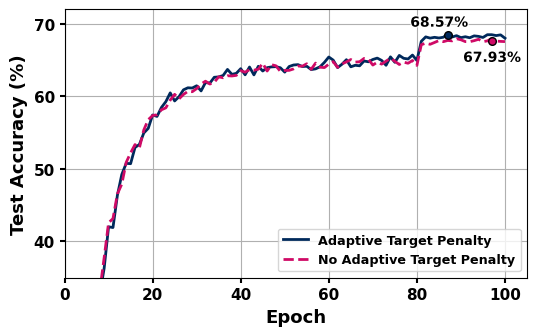

In [ ]:
########################################################################################################################
####-------| NOTE 13.  ADAPTIVE REGULARIZATION VS NO ADAPTIVE REGULARIZATION | XXX -----------------####################
########################################################################################################################



import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects
import os

def read_test_log(file_path):
    test_loss_history = []
    test_acc_history = []
    with open(file_path, 'r') as f:
        for line in f:
            if "Test Loss" in line and "Test Acc" in line:
                try:
                    loss = float(line.split("Test Loss:")[1].split("|")[0].strip())
                    acc = float(line.split("Test Acc:")[1].split("%")[0].strip())
                    test_loss_history.append(loss)
                    test_acc_history.append(acc)
                except:
                    continue
    return test_loss_history, test_acc_history

def plot_train_test_metrics(save_dir="./Results/Plots"):
    os.makedirs(save_dir, exist_ok=True)



    TargetPenalty_test_log_path = f'./Results_AdaptiveTarget/CIFAR100_Test_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'
    noTargetPenalty_test_log_path = f'./Results/CIFAR100_Test_{target_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'


    TargetPenalty_test_loss, TargetPenalty_test_acc = read_test_log(TargetPenalty_test_log_path)
    noTargetPenalty_test_loss, noTargetPenalty_test_acc = read_test_log(noTargetPenalty_test_log_path)

    num_epochs = min(len(TargetPenalty_test_loss), len(noTargetPenalty_test_loss))
    epochs = range(1, num_epochs + 1)

    COLOR_SCALE = ['#00295B', '#CF0A66']  # TargetPenalty, noTargetPenalty
    rcParams.update({
        "font.size": 11,
        "axes.titlesize": 11,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.labelweight": "bold",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    # Custom settings
    custom_yticks_test_loss = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    custom_yticks_test_acc = [10, 20, 30, 40, 50, 60, 70]
    custom_xticks = [0, 20, 40, 60, 80, 100]
    custom_yaxis_test_loss = [1.2, 4.2]
    custom_yaxis_test_acc = [35, 72]
    custom_xaxis = [0, 105]

    # Offsets
    y_offset_loss_tp = 0.2
    y_offset_loss_ntp = 0.07
    x_offset_loss_tp = 3.5
    x_offset_loss_ntp = 3.5

    y_offset_acc_tp = 1
    y_offset_acc_ntp = 3.2
    x_offset_acc_tp = 8.5
    x_offset_acc_ntp = 6.5

    # 🔷 Plot Test Loss
    fig1, ax1 = plt.subplots(figsize=(5.5, 3.5))
    ax1.plot(epochs, TargetPenalty_test_loss[:num_epochs], label="TargetPenalty", color=COLOR_SCALE[0], linewidth=2)
    ax1.plot(epochs, noTargetPenalty_test_loss[:num_epochs], label="No TargetPenalty", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax1.set_xlabel("Epoch", fontweight='bold')
    ax1.set_ylabel("Test Loss", fontweight='bold')
    ax1.set_xticks(custom_xticks)
    ax1.set_yticks(custom_yticks_test_loss)
    ax1.set_xlim(custom_xaxis)
    ax1.set_ylim(custom_yaxis_test_loss)
    ax1.tick_params(axis='x', width=1.5)
    ax1.tick_params(axis='y', width=1.5)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    leg1 = ax1.legend(fontsize='small', loc="upper right")
    for text in leg1.get_texts():
        text.set_fontweight('bold')
    ax1.grid(True)

    # Add final loss markers
    ax1.plot(epochs[-1], TargetPenalty_test_loss[-1], marker='o', color=COLOR_SCALE[0], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_tp, TargetPenalty_test_loss[-1] - y_offset_loss_tp,
             f"{TargetPenalty_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax1.plot(epochs[-1], noTargetPenalty_test_loss[-1], marker='o', color=COLOR_SCALE[1], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_ntp, noTargetPenalty_test_loss[-1] + y_offset_loss_ntp,
             f"{noTargetPenalty_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_loss_targetpenalty_vs_no_targetpenalty.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    plt.close(fig1)

    # 🔶 Plot Test Accuracy
    best_epoch_tp = TargetPenalty_test_acc.index(max(TargetPenalty_test_acc)) + 1
    best_acc_tp = max(TargetPenalty_test_acc)
    best_epoch_ntp = noTargetPenalty_test_acc.index(max(noTargetPenalty_test_acc)) + 1
    best_acc_ntp = max(noTargetPenalty_test_acc)

    fig2, ax2 = plt.subplots(figsize=(5.5, 3.5))
    ax2.plot(epochs, TargetPenalty_test_acc[:num_epochs], label="Adaptive Target Penalty", color=COLOR_SCALE[0], linewidth=2)
    ax2.plot(epochs, noTargetPenalty_test_acc[:num_epochs], label="No Adaptive Target Penalty", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax2.set_xlabel("Epoch", fontweight='bold')
    ax2.set_ylabel("Test Accuracy (%)", fontweight='bold')
    ax2.set_xticks(custom_xticks)
    ax2.set_yticks(custom_yticks_test_acc)
    ax2.set_xlim(custom_xaxis)
    ax2.set_ylim(custom_yaxis_test_acc)
    ax2.tick_params(axis='x', width=1.5)
    ax2.tick_params(axis='y', width=1.5)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    leg2 = ax2.legend(fontsize='small', loc="lower right")
    for text in leg2.get_texts():
        text.set_fontweight('bold')
    ax2.grid(True)

    # Markers for best accuracy
    ax2.plot(best_epoch_tp, best_acc_tp - 0.21, marker='o', color=COLOR_SCALE[0], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_tp - x_offset_acc_tp, best_acc_tp + y_offset_acc_tp,
             f"{best_acc_tp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax2.plot(best_epoch_ntp, best_acc_ntp - 0.4, marker='o', color=COLOR_SCALE[1], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_ntp - x_offset_acc_ntp, best_acc_ntp - y_offset_acc_ntp,
             f"{best_acc_ntp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_accuracy_targetpenalty_vs_no_targetpenalty.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    # plt.close(fig2)

    return f"✅ Annotated comparison plots with BEST accuracy markers saved to {save_dir}"

# 🔷 Call the function
plot_train_test_metrics()